In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.simbad import Simbad
from photutils import DAOStarFinder, CircularAperture, SkyCircularAperture, CircularAnnulus, aperture_photometry, Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, Column, hstack
import numpy
import os
import pylab
import glob
import seaborn as sns
from dateutil.parser import parse
from scipy.stats import sigmaclip
from astropy.stats import median_absolute_deviation, SigmaClip
import traceback
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import coordinates as coord


Bad key "text.kerning_factor" on line 4 in
/home/utsumi/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
coef={
    "FLUX_R": 1.42e9,
    "FLUX_I": 1.00e9,
    "FLUX_u": 4.46e8,
    "FLUX_U": 4.46e8
}

AB = {
    "FLUX_R": 0.0,
    "FLUX_I": 0.0,
    "FLUX_u": 0.0,
    "FLUX_U": 0.0
}

AB = {
    "FLUX_R": 0.21,
    "FLUX_I": 0.45,
    "FLUX_u": 0.91,
    "FLUX_U": 0.91
}
glassbanketc = {
    "u": 0.59,   # take out a mirror because DM installed
    "Rc": 0.61,  # take out a mirror because DM installed
    "Ic": 0.55
}

def R(lam,t):
    alpha = numpy.exp(-2.3/100*t)
    theta = 0./180*numpy.pi
    sigma = 10+40*t
    return alpha*numpy.exp(-(4*numpy.pi*sigma*numpy.cos(theta)/lam)**2)

#lam = numpy.arange(3000,10000)
#for i in range(0,10):
#    pylab.plot(lam,R(lam,i))

lam = {
    "u": 3500.,
    "Rc": 6600.,
    "Ic": 8000.
}

In [3]:
def preprocess(path):
    # load fits file
    fh = fits.open(path)

    # reduce data
    header = fh[0].header
    data = fh[0].data[:header["MaxImgRows"], :header["MaxImgCols"]]
#    data = fh[0].data
    bias = numpy.outer(
        numpy.median(fh[0].data[:,header["MaxImgCols"]+10:],axis=1),
        numpy.ones(data.shape[1]))  # avoiding first 10 cols, row-by-row operation
    data = data - bias

    # sky subtraction
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()

    # dividing the whole image by 4 in row
    for i in range(4):
        subsection = data[512*i:512*(i+1)]
        bkg = Background2D( subsection, (30, 30), filter_size=(3, 3),
                       sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
        data[512*i:512*(i+1)] = subsection - bkg.background
    
    new=fits.PrimaryHDU(data=data,header=header)
    new.writeto("{}".format("/".join(
        [os.path.dirname(os.path.abspath(path)),"bg"+os.path.basename(path)]
    )), overwrite=True)
    
    return data, header
    

In [4]:
def getrefcatalog( wcs ):
    # retrieve reference catalog
    c = SkyCoord(wcs.wcs.crval[0]*u.deg,wcs.wcs.crval[1]*u.deg)
    r = 15 * u.arcminute
    customSimbad = Simbad()
    customSimbad.add_votable_fields(
        "flux(u)",
        "flux_error(U)",
        "flux_system(U)",
        "flux_unit(U)",
        "flux(U)",
        "flux_error(U)",
        "flux_system(U)",
        "flux_unit(U)",
        "flux(R)",
        "flux_error(R)",
        "flux_system(R)",
        "flux_unit(R)",
        "flux(I)",
        "flux_error(I)",
        "flux_system(I)",
        "flux_unit(I)"
        )
    reference = customSimbad.query_region(c, radius=r)
    refcoord=SkyCoord(reference["RA"],reference["DEC"],unit=(u.hourangle, u.deg))
    return reference, refcoord

In [5]:
def getthroughput(path,data=None,header=None,reference=None,refcoord=None,wcs=None,plot=False,tol=1*u.arcsec):
    if header is None:
        data, header=preprocess(path)
    if wcs is None:
        wcs = WCS(header)
    filterkey = "FLUX_{}".format(header["FILTER"][0].upper())
#    filterkey = "FLUX_{}".format(header["FILTER"][0])
    print(filterkey)
    if reference is None:
        reference, refcoord = getrefcatalog(wcs)
    #    data = fh[0].data
    # detect objectcoef, need to optmize FWHM size
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
    daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
    sources=daofind(data-median)
    # define positions where we measure
    positions = numpy.transpose([sources["xcentroid"], sources["ycentroid"]])
    aperture = CircularAperture(positions, r=5)
    annulus_aperture = CircularAnnulus(positions, r_in=8, r_out=10)
    # do photometry
    table = aperture_photometry(data,[aperture,annulus_aperture],wcs=wcs)
    table["flux"] = table["aperture_sum_0"]-table["aperture_sum_1"]*aperture.area/annulus_aperture.area    
#    idx, d2d, d3d = SkyCoord(wcs.all_pix2world((positions+xyoff),0),unit=("deg","deg")).match_to_catalog_sky(refcoord)    
    idx, d2d, d3d = aperture.to_sky(wcs).positions.match_to_catalog_sky(refcoord)
    table["d2d"] = d2d.to("arcsec")
    merged = hstack([Table(table), reference[idx]])[d2d<tol]

    obs = merged["flux"]*header["GAIN"]/header["EXPTIME"] # e-/sec
    expected = coef[filterkey]*10**(-0.4*(merged[filterkey]+AB[filterkey]))
    x = obs/expected
    c, low, upp = sigmaclip(x[numpy.where((x>0.1)&(x<1))])
    med = numpy.nanmedian(c)
    err = median_absolute_deviation(c)

    if plot:
        ### PLOT IMAGE
        fig = pylab.figure(figsize=(5,5),dpi=200)
        pylab.subplot(projection=wcs)
        sky=numpy.median(data)
        std=median_absolute_deviation(data)
        aperture.plot(color='white', lw=0.1)
        annulus_aperture.plot(color='red', lw=0.1)

        pylab.imshow(data,origin="lower left",vmin=sky-3*std,vmax=sky+10*std,cmap="gray")

        refaperture = SkyCircularAperture(
            refcoord[(reference[filterkey]>0)&(reference[filterkey]<25)], r=2.*u.arcsec
        ).to_pixel(wcs)
        refaperture.plot(color="green", lw=2, alpha=0.5)
        pylab.show()
        pylab.clf()

        ### CHECK PLOT
        sns.set(style="darkgrid")
        tips = sns.load_dataset("tips")

        #g = sns.JointGrid(x="total_bill", y="tip", data=tips)
        g = sns.JointGrid( merged[filterkey], x,ylim=(-0.05,1.05))
    #    g = sns.JointGrid( merged[filterkey], obs/expected )
    #    g.plot_joint(sns.kdeplot)
        g.plot_joint(sns.scatterplot)
        g.ax_marg_x.hist(
            merged[filterkey],
            bins=numpy.arange(11,20,0.5)
        )
        g.ax_marg_y.hist(
            obs/expected,
            orientation="horizontal",
            bins=numpy.arange(0,1,0.05)
        )
        g.set_axis_labels(xlabel="mag", ylabel="Throughput")

        pylab.axhline(med)    
        pylab.axhspan(med-err, med+err, alpha=0.5)
        pylab.suptitle(filterkey)

    return { "median": med, "std": err}, header

In [6]:
def loopover( target, offset ):
    files = glob.glob(target)
    order = [2,1,0]
    result = {}
    for i, afile in enumerate(files):
        data, header, wcs, reference, refcoord = None, None, None, None, None
        for j in order:
            try:
                path = afile.replace("-2","-{}".format(j))
                if j == order[0]:
                    data, header = preprocess(afile)
                    wcs = WCS(header)
                    reference, refcoord=getrefcatalog(wcs)
                if j == order[1]:
                    wcs = None
                if j == order[2]:
                    a=WCS(header).wcs
                    a.crpix = a.crpix-numpy.array(offset)
                    wcs = WCS(a.to_header())
                    path = "/".join(
                        os.path.dirname(path).split("/")[:-1]+[os.path.basename(path).replace(".new",".fits")]
                    )
                print ("{}/{}".format(i,len(files)))
                print (wcs,offset)
                try:
                    print (path)
                    if j==order[2]:
                        plot = False
                        tol = 5*u.arcsec ### tolearance for u-band 
                    else:
                        plot = False
                        tol = 1*u.arcsec
                    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
                    print (res)
                    dt = parse("{}T{}".format(header["DATE-OBS"],header["UT"]))
                    try:
                        result[resheader["FILTER"]]["dt"].append( dt )
                        result[resheader["FILTER"]]["median"].append( res["median"] )
                        result[resheader["FILTER"]]["std"].append( res["std"] )
                    except:
                        result[resheader["FILTER"]] = {
                            "dt": [ dt ],
                            "median": [ res["median"] ], "std": [ res["std"] ] }
                except:
                    traceback.print_exc()
            except:
                traceback.print_exc()
    return result

In [30]:
def mkplot( result, site, target, year, air ):
    obstime = []
    ra = []
    dec = []
    for afile in glob.glob(target):
        with fits.open(afile) as fh:
            header = fh[0].header
            obstime.append(parse("{}T{} UT ".format(header["DATE-OBS"],header["UT"])))
            ra  = header["RA"]
            dec = header["DEC"]

    aa_frame = coord.AltAz(
        obstime=obstime,
        location=site)
    ret = SkyCoord(ra,dec,unit=("hour","deg")).transform_to(aa_frame)

    fig = pylab.figure(figsize=(5,5),dpi=200)
    sub=pylab.subplot(211)
    pylab.subplots_adjust(top=1.3,hspace=0)
    for key in ["u","Rc","Ic"]:
        try:
            x = numpy.array(result[key]["dt"])
            y = numpy.array(result[key]["median"])/air
            yerr = numpy.array(result[key]["std"])
            cond = numpy.where(((yerr/y)<.15)&(y>0.1))
            data = pylab.errorbar(
                x[cond],
                (y/glassbanketc[key])[cond],
                yerr=(yerr/glassbanketc[key])[cond],
                fmt="o",label=key)
            pylab.axhline(1,color="k")
            pylab.axhline(R(lam[key],year),color=data[0].get_color())    
            pylab.axhspan(R(lam[key],year-1),R(lam[key],year+1),alpha=0.2,color=data[0].get_color())    
        except:
            traceback.print_exc()

    pylab.ylim(0,1.2)
    pylab.legend()
    pylab.ylabel("Relative Transparency to the Expectation")        
    pylab.subplot(212,sharex=sub)
    pylab.plot_date(ret.obstime.value, ret.alt)
    pylab.ylabel("Altitude")
    pylab.xlabel("UT")
    pylab.ylim(0,90)
    fig.autofmt_xdate()
#pylab.tight_layout()

(0, 1)

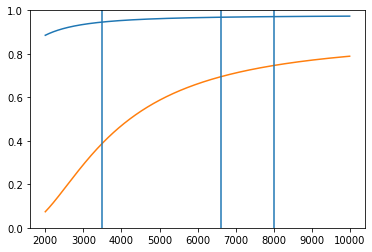

In [8]:
x = numpy.arange(2000,10000,10)
for t in [1,6]:
    pylab.plot(x,R(x,t))
for x in lam.keys():
    pylab.axvline(lam[x])
pylab.ylim(0,1)

# Ali data analysis

In [31]:
target = "fwhm/HT*-2/HT*.new"
offset = [-5,14] # for u-band coase alignment

In [9]:
result = loopover(target,offset)

0/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773333895  13.4350131563  
CRPIX : 810.778289795  554.337314606  
CD1_1 CD1_2  : 0.000188040296777  7.24863329823e-07  
CD2_1 CD2_2  : -6.51681946937e-07  0.000186515411922  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000159-2/HT0000159-2.new
FLUX_I


{'median': 0.3808659126254945, 'std': 0.004089454057105202}
0/95
None [-5, 14]
fwhm/HT0000159-1/HT0000159-1.new
FLUX_R


{'median': 0.4288161939333917, 'std': 0.003765446505406056}
0/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773333895  13.4350131563  
CRPIX : 815.778289795  540.337314606  
PC1_1 PC1_2  : 0.000188040296777  7.24863329823e-07  
PC2_1 PC2_2  : -6.51681946937e-07  0.000186515411922  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000159-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
1/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251163634  -0.0230606331836  
CRPIX : 922.60568428  606.656505585  
CD1_1 CD1_2  : 0.000188035529337  6.29457993905e-07  
CD2_1 CD2_2  : -6.57684807731e-07  0.000186461160315  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000165-2/HT0000165-2.new
FLUX_I


{'median': 0.36769224044769827, 'std': 0.010719541238306401}
1/95
None [-5, 14]
fwhm/HT0000165-1/HT0000165-1.new
FLUX_R


{'median': 0.4514569960512169, 'std': 0.03457778854939819}
1/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251163634  -0.0230606331836  
CRPIX : 927.60568428  592.656505585  
PC1_1 PC1_2  : 0.000188035529337  6.29457993905e-07  
PC2_1 PC2_2  : -6.57684807731e-07  0.000186461160315  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000165-0.fits
FLUX_U


{'median': 0.276616408730328, 'std': 0.0}
2/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732206932  85.3077506809  
CRPIX : 868.372879028  962.380828857  
CD1_1 CD1_2  : 0.000188089156595  -3.3177381176e-06  
CD2_1 CD2_2  : 3.35361226268e-06  0.000186398664922  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000250-2/HT0000250-2.new
FLUX_I


{'median': 0.37432343605703156, 'std': 0.011210249607311096}
2/95
None [-5, 14]
fwhm/HT0000250-1/HT0000250-1.new
FLUX_R


{'median': 0.4569860709319945, 'std': 0.013536188440475494}
2/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732206932  85.3077506809  
CRPIX : 873.372879028  948.380828857  
PC1_1 PC1_2  : 0.000188089156595  -3.3177381176e-06  
PC2_1 PC2_2  : 3.35361226268e-06  0.000186398664922  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000250-0.fits
FLUX_U


{'median': 0.27334142265807765, 'std': 0.0}
3/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732346742  85.3077811158  
CRPIX : 870.849960327  971.664432526  
CD1_1 CD1_2  : 0.000188082396996  -3.29311680679e-06  
CD2_1 CD2_2  : 3.34296863636e-06  0.000186423855946  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000290-2/HT0000290-2.new
FLUX_I


{'median': 0.38309871386439476, 'std': 0.014340613726357115}
3/95
None [-5, 14]
fwhm/HT0000290-1/HT0000290-1.new
FLUX_R


{'median': 0.46098469210259324, 'std': 0.015894969118655566}
3/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732346742  85.3077811158  
CRPIX : 875.849960327  957.664432526  
PC1_1 PC1_2  : 0.000188082396996  -3.29311680679e-06  
PC2_1 PC2_2  : 3.34296863636e-06  0.000186423855946  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000290-0.fits
FLUX_U


{'median': 0.2745149312840611, 'std': 0.013845613810424845}
4/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733139914  85.30777294  
CRPIX : 875.772537231  1018.69539642  
CD1_1 CD1_2  : 0.000188133148915  -3.17332087191e-06  
CD2_1 CD2_2  : 3.29839965237e-06  0.000186414719738  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000454-2/HT0000454-2.new
FLUX_I


{'median': 0.37168017663506425, 'std': 0.013639146513522493}
4/95
None [-5, 14]
fwhm/HT0000454-1/HT0000454-1.new
FLUX_R


{'median': 0.44337781369807516, 'std': 0.013625461384521337}
4/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733139914  85.30777294  
CRPIX : 880.77253723  1004.69539642  
PC1_1 PC1_2  : 0.000188133148915  -3.17332087191e-06  
PC2_1 PC2_2  : 3.29839965237e-06  0.000186414719738  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000454-0.fits
FLUX_U


{'median': 0.4641365949386983, 'std': 0.20275312108484844}
5/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733232425  85.3077707876  
CRPIX : 874.648864746  981.566307068  
CD1_1 CD1_2  : 0.000188084171972  -3.25953610862e-06  
CD2_1 CD2_2  : 3.3451242937e-06  0.00018640520013  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000331-2/HT0000331-2.new
FLUX_I


{'median': 0.37835438383392617, 'std': 0.013070105237206864}
5/95
None [-5, 14]
fwhm/HT0000331-1/HT0000331-1.new
FLUX_R


{'median': 0.4545871543527943, 'std': 0.014698864837516812}
5/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733232425  85.3077707876  
CRPIX : 879.648864746  967.566307068  
PC1_1 PC1_2  : 0.000188084171972  -3.25953610862e-06  
PC2_1 PC2_2  : 3.3451242937e-06  0.00018640520013  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000331-0.fits
FLUX_U


{'median': 0.2699068166839244, 'std': 0.008313101260930322}
6/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733133928  85.3077537405  
CRPIX : 876.264587402  987.568511963  
CD1_1 CD1_2  : 0.000188127829012  -3.25195521606e-06  
CD2_1 CD2_2  : 3.32563518452e-06  0.000186429252042  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000350-2/HT0000350-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.37041600407355363, 'std': 0.010974427837504186}
6/95
None [-5, 14]
fwhm/HT0000350-1/HT0000350-1.new
6/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733133928  85.3077537405  
CRPIX : 881.264587402  973.568511963  
PC1_1 PC1_2  : 0.000188127829012  -3.25195521606e-06  
PC2_1 PC2_2  : 3.32563518452e-06  0.000186429252042  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000350-0.fits
FLUX_U


{'median': 0.44311085492034474, 'std': 0.18743313671437412}
7/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.55365283  5.85239140653  
CRPIX : 1546.16574097  1139.90052414  
CD1_1 CD1_2  : 0.000187888940219  8.83265280018e-07  
CD2_1 CD2_2  : -1.10396532958e-06  0.000186285451558  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000126-2/HT0000126-2.new
FLUX_I


{'median': 0.3756187860609388, 'std': 0.006401040001647207}
7/95
None [-5, 14]
fwhm/HT0000126-1/HT0000126-1.new
FLUX_R


{'median': 0.44102905855331537, 'std': 0.0076543696483949986}
7/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.55365283  5.85239140653  
CRPIX : 1551.16574097  1125.90052414  
PC1_1 PC1_2  : 0.000187888940219  8.83265280018e-07  
PC2_1 PC2_2  : -1.10396532958e-06  0.000186285451558  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000126-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
8/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732134593  85.307772622  
CRPIX : 872.846618652  976.38123703  
CD1_1 CD1_2  : 0.000188121607804  -3.28100715529e-06  
CD2_1 CD2_2  : 3.34551841981e-06  0.00018641663734  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000310-2/HT0000310-2.new
FLUX_I


{'median': 0.3798538340835462, 'std': 0.013378817268114962}
8/95
None [-5, 14]
fwhm/HT0000310-1/HT0000310-1.new
FLUX_R


{'median': 0.4539084483659712, 'std': 0.014238886188259109}
8/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732134593  85.307772622  
CRPIX : 877.846618652  962.38123703  
PC1_1 PC1_2  : 0.000188121607804  -3.28100715529e-06  
PC2_1 PC2_2  : 3.34551841981e-06  0.00018641663734  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000310-0.fits
FLUX_U


{'median': 0.2804655347196586, 'std': 0.0}
9/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735285198  85.3077363786  
CRPIX : 813.712600708  889.326057434  
CD1_1 CD1_2  : 0.000188022736273  -3.28443126603e-06  
CD2_1 CD2_2  : 3.36207336174e-06  0.000186377158373  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000142-2/HT0000142-2.new
FLUX_I


{'median': 0.35069212655985665, 'std': 0.010053036980165991}
9/95
None [-5, 14]
fwhm/HT0000142-1/HT0000142-1.new
FLUX_R


{'median': 0.4311457633904309, 'std': 0.013585140799169088}
9/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735285198  85.3077363786  
CRPIX : 818.712600708  875.326057434  
PC1_1 PC1_2  : 0.000188022736273  -3.28443126603e-06  
PC2_1 PC2_2  : 3.36207336174e-06  0.000186377158373  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000142-0.fits
FLUX_U


{'median': 0.5732041935324514, 'std': 0.09727675063858054}
10/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732718781  85.3077691064  
CRPIX : 868.41418457  961.909606934  
CD1_1 CD1_2  : 0.000188091008067  -3.3261104545e-06  
CD2_1 CD2_2  : 3.36799391003e-06  0.000186425887178  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000248-2/HT0000248-2.new
FLUX_I


{'median': 0.3808263107644523, 'std': 0.013708202166544503}
10/95
None [-5, 14]
fwhm/HT0000248-1/HT0000248-1.new
FLUX_R


{'median': 0.45395390041697103, 'std': 0.014731295528743749}
10/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732718781  85.3077691064  
CRPIX : 873.41418457  947.909606934  
PC1_1 PC1_2  : 0.000188091008067  -3.3261104545e-06  
PC2_1 PC2_2  : 3.36799391003e-06  0.000186425887178  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000248-0.fits
FLUX_U


{'median': 0.2811443704630711, 'std': 0.04438812601911685}
11/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731842198  85.3077731324  
CRPIX : 870.218963623  966.019226074  
CD1_1 CD1_2  : 0.000188083139515  -3.3113860586e-06  
CD2_1 CD2_2  : 3.36435800646e-06  0.000186420681383  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000269-2/HT0000269-2.new
FLUX_I


{'median': 0.37930459230161845, 'std': 0.013586924754880547}
11/95
None [-5, 14]
fwhm/HT0000269-1/HT0000269-1.new
FLUX_R


{'median': 0.4564505261920075, 'std': 0.013845863126298513}
11/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731842198  85.3077731324  
CRPIX : 875.218963623  952.019226074  
PC1_1 PC1_2  : 0.000188083139515  -3.3113860586e-06  
PC2_1 PC2_2  : 3.36435800646e-06  0.000186420681383  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000269-0.fits
FLUX_U


{'median': 0.26165868750190513, 'std': 0.009967297219701576}
12/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732434173  85.3077471286  
CRPIX : 874.631652832  1024.15116882  
CD1_1 CD1_2  : 0.000188138511595  -3.16467236099e-06  
CD2_1 CD2_2  : 3.27677796292e-06  0.00018642398259  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000473-2/HT0000473-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3575859671970404, 'std': 0.010457200990845905}
12/95
None [-5, 14]
fwhm/HT0000473-1/HT0000473-1.new
12/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732434173  85.3077471286  
CRPIX : 879.63165283  1010.15116882  
PC1_1 PC1_2  : 0.000188138511595  -3.16467236099e-06  
PC2_1 PC2_2  : 3.27677796292e-06  0.00018642398259  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000473-0.fits
FLUX_U


{'median': 0.5370543045721624, 'std': 0.2966310606095124}
13/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173242741  85.3077613756  
CRPIX : 867.724533081  1039.01070786  
CD1_1 CD1_2  : 0.000188152682136  -3.11625415402e-06  
CD2_1 CD2_2  : 3.28143406042e-06  0.000186425804556  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000515-2/HT0000515-2.new
FLUX_I


{'median': 0.36869920318427224, 'std': 0.011926174100615028}
13/95
None [-5, 14]
fwhm/HT0000515-1/HT0000515-1.new
FLUX_R


{'median': 0.43624441297527133, 'std': 0.0119371017408883}
13/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173242741  85.3077613756  
CRPIX : 872.72453308  1025.01070786  
PC1_1 PC1_2  : 0.000188152682136  -3.11625415402e-06  
PC2_1 PC2_2  : 3.28143406042e-06  0.000186425804556  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000515-0.fits
FLUX_U


{'median': 0.2521299649240518, 'std': 0.0}
14/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553654449  5.85238360827  
CRPIX : 1566.55923462  1141.03749084  
CD1_1 CD1_2  : 0.000187881838943  8.70547642685e-07  
CD2_1 CD2_2  : -1.10383609219e-06  0.000186270165517  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000125-2/HT0000125-2.new
FLUX_I


{'median': 0.38664806473185814, 'std': 0.0013706774880324346}
14/95
None [-5, 14]
fwhm/HT0000125-1/HT0000125-1.new
FLUX_R


{'median': 0.45434190231212523, 'std': 0.0019914317403281756}
14/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553654449  5.85238360827  
CRPIX : 1571.55923462  1127.03749084  
PC1_1 PC1_2  : 0.000187881838943  8.70547642685e-07  
PC2_1 PC2_2  : -1.10383609219e-06  0.000186270165517  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000125-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
15/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251117637  -0.0230662372278  
CRPIX : 904.013536453  613.340744019  
CD1_1 CD1_2  : 0.000188099732372  5.92503770739e-07  
CD2_1 CD2_2  : -7.1395500236e-07  0.0001864850212  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000157-2/HT0000157-2.new
FLUX_I


{'median': 0.3332840996054654, 'std': 0.007758122480471641}
15/95
None [-5, 14]
fwhm/HT0000157-1/HT0000157-1.new
FLUX_R


{'median': 0.40064022923650977, 'std': 0.014717385516840875}
15/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251117637  -0.0230662372278  
CRPIX : 909.013536453  599.340744019  
PC1_1 PC1_2  : 0.000188099732372  5.92503770739e-07  
PC2_1 PC2_2  : -7.1395500236e-07  0.0001864850212  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000157-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
16/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732608078  85.3077474756  
CRPIX : 865.612640381  943.306774139  
CD1_1 CD1_2  : 0.000188084568022  -3.3490978357e-06  
CD2_1 CD2_2  : 3.41851159104e-06  0.000186441467309  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000206-2/HT0000206-2.new
FLUX_I


{'median': 0.3655461018751266, 'std': 0.011604209517715847}
16/95
None [-5, 14]
fwhm/HT0000206-1/HT0000206-1.new
FLUX_R


{'median': 0.4302852792902911, 'std': 0.011677819065475936}
16/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732608078  85.3077474756  
CRPIX : 870.612640381  929.306774139  
PC1_1 PC1_2  : 0.000188084568022  -3.3490978357e-06  
PC2_1 PC2_2  : 3.41851159104e-06  0.000186441467309  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000206-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
17/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5195765036  85.2984006267  
CRPIX : 1360.07688141  826.838890076  
CD1_1 CD1_2  : 0.000188135167105  1.14044812973e-06  
CD2_1 CD2_2  : -1.11518783782e-06  0.000186384857343  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000112-2/HT0000112-2.new
FLUX_I


{'median': 0.3560609998710404, 'std': 0.012199686374728513}
17/95
None [-5, 14]
fwhm/HT0000112-1/HT0000112-1.new
FLUX_R


{'median': 0.4221275326593416, 'std': 0.012595724198647684}
17/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5195765036  85.2984006267  
CRPIX : 1365.07688141  812.83889008  
PC1_1 PC1_2  : 0.000188135167105  1.14044812973e-06  
PC2_1 PC2_2  : -1.11518783782e-06  0.000186384857343  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000112-0.fits
FLUX_U


{'median': 0.21832784994694618, 'std': 0.0013523140446885518}
18/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733051363  85.3077717128  
CRPIX : 876.747009277  993.82125473  
CD1_1 CD1_2  : 0.000188084967073  -3.23859427244e-06  
CD2_1 CD2_2  : 3.3244009104e-06  0.000186409951346  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000372-2/HT0000372-2.new
FLUX_I


{'median': 0.3788747362218298, 'std': 0.014051049745543609}
18/95
None [-5, 14]
fwhm/HT0000372-1/HT0000372-1.new
FLUX_R


{'median': 0.4511186783114578, 'std': 0.015065372849252023}
18/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733051363  85.3077717128  
CRPIX : 881.747009277  979.82125473  
PC1_1 PC1_2  : 0.000188084967073  -3.23859427244e-06  
PC2_1 PC2_2  : 3.3244009104e-06  0.000186409951346  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000372-0.fits
FLUX_U


{'median': 0.27097436148218146, 'std': 0.0012616068929892366}
19/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773337394  13.4350112884  
CRPIX : 801.824737549  533.616855621  
CD1_1 CD1_2  : 0.000188062446986  7.02563294709e-07  
CD2_1 CD2_2  : -6.77050159756e-07  0.000186526866447  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000132-2/HT0000132-2.new
FLUX_I


{'median': 0.3960610042648576, 'std': 0.007138283651251132}
19/95
None [-5, 14]
fwhm/HT0000132-1/HT0000132-1.new
FLUX_R


{'median': 0.44728680631429646, 'std': 0.000975093572120056}
19/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8773337394  13.4350112884  
CRPIX : 806.824737549  519.616855621  
PC1_1 PC1_2  : 0.000188062446986  7.02563294709e-07  
PC2_1 PC2_2  : -6.77050159756e-07  0.000186526866447  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000132-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
20/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733020615  85.3077465251  
CRPIX : 874.376815796  982.59122467  
CD1_1 CD1_2  : 0.000188076417785  -3.26122691271e-06  
CD2_1 CD2_2  : 3.33017880626e-06  0.000186384986537  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000333-2/HT0000333-2.new
FLUX_I


{'median': 0.36721598433136277, 'std': 0.010754978841053142}
20/95
None [-5, 14]
fwhm/HT0000333-1/HT0000333-1.new
FLUX_R


{'median': 0.4523167901155951, 'std': 0.012623704088631726}
20/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733020615  85.3077465251  
CRPIX : 879.376815796  968.59122467  
PC1_1 PC1_2  : 0.000188076417785  -3.26122691271e-06  
PC2_1 PC2_2  : 3.33017880626e-06  0.000186384986537  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000333-0.fits
FLUX_U


{'median': 0.2717633183283663, 'std': 0.039211628671656035}
21/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553656232  5.85234791482  
CRPIX : 1568.22003174  1145.48963165  
CD1_1 CD1_2  : 0.000187883223872  9.15548123083e-07  
CD2_1 CD2_2  : -1.1263956068e-06  0.000186286589236  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000164-2/HT0000164-2.new
FLUX_I


{'median': 0.3880098589702712, 'std': 0.005291814907247561}
21/95
None [-5, 14]
fwhm/HT0000164-1/HT0000164-1.new
FLUX_R


{'median': 0.45250844239645965, 'std': 0.0008968477654832108}
21/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553656232  5.85234791482  
CRPIX : 1573.22003174  1131.48963165  
PC1_1 PC1_2  : 0.000187883223872  9.15548123083e-07  
PC2_1 PC2_2  : -1.1263956068e-06  0.000186286589236  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000164-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
22/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732731672  85.3077581919  
CRPIX : 877.001220703  993.290611267  
CD1_1 CD1_2  : 0.00018812513026  -3.23871852728e-06  
CD2_1 CD2_2  : 3.31995270832e-06  0.000186418473576  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000371-2/HT0000371-2.new
FLUX_I


{'median': 0.37229965741311777, 'std': 0.012768779202820935}
22/95
None [-5, 14]
fwhm/HT0000371-1/HT0000371-1.new
FLUX_R


{'median': 0.4361052435433872, 'std': 0.01105215893368483}
22/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732731672  85.3077581919  
CRPIX : 882.001220703  979.290611267  
PC1_1 PC1_2  : 0.00018812513026  -3.23871852728e-06  
PC2_1 PC2_2  : 3.31995270832e-06  0.000186418473576  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000371-0.fits
FLUX_U


{'median': 0.26007748326365177, 'std': 0.0}
23/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733167907  85.3077472985  
CRPIX : 861.368759155  1052.3468132  
CD1_1 CD1_2  : 0.000188144719618  -3.0901280159e-06  
CD2_1 CD2_2  : 3.24397187904e-06  0.000186430040452  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000555-2/HT0000555-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3568446224485762, 'std': 0.009387690801947124}
23/95
None [-5, 14]
fwhm/HT0000555-1/HT0000555-1.new
23/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733167907  85.3077472985  
CRPIX : 866.36875916  1038.3468132  
PC1_1 PC1_2  : 0.000188144719618  -3.0901280159e-06  
PC2_1 PC2_2  : 3.24397187904e-06  0.000186430040452  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000555-0.fits
FLUX_U


{'median': 0.22816072447882949, 'std': 0.0}
24/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731735952  85.3077550214  
CRPIX : 861.927963257  941.194225311  
CD1_1 CD1_2  : 0.000188071582593  -3.36659809957e-06  
CD2_1 CD2_2  : 3.40310137452e-06  0.000186454714784  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000186-2/HT0000186-2.new
FLUX_I


{'median': 0.3709025304972454, 'std': 0.011003357280431975}
24/95
None [-5, 14]
fwhm/HT0000186-1/HT0000186-1.new
FLUX_R


{'median': 0.44018108099717385, 'std': 0.012810461304588738}
24/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731735952  85.3077550214  
CRPIX : 866.927963257  927.194225311  
PC1_1 PC1_2  : 0.000188071582593  -3.36659809957e-06  
PC2_1 PC2_2  : 3.40310137452e-06  0.000186454714784  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000186-0.fits
FLUX_U


{'median': 0.2631381098001059, 'std': 0.0022980928042887483}
25/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173288689  85.3077463743  
CRPIX : 865.261642456  943.453250885  
CD1_1 CD1_2  : 0.000188053186937  -3.35546496605e-06  
CD2_1 CD2_2  : 3.40917624332e-06  0.000186439910762  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000207-2/HT0000207-2.new
FLUX_I


{'median': 0.362071171598479, 'std': 0.011811585001366531}
25/95
None [-5, 14]
fwhm/HT0000207-1/HT0000207-1.new
FLUX_R


{'median': 0.43154213274679654, 'std': 0.012795458108659064}
25/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173288689  85.3077463743  
CRPIX : 870.261642456  929.453250885  
PC1_1 PC1_2  : 0.000188053186937  -3.35546496605e-06  
PC2_1 PC2_2  : 3.40917624332e-06  0.000186439910762  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000207-0.fits
FLUX_U


{'median': 0.14941450381837887, 'std': 0.0}
26/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732111732  85.3077546783  
CRPIX : 867.570541382  946.688266754  
CD1_1 CD1_2  : 0.000188083656165  -3.34861161907e-06  
CD2_1 CD2_2  : 3.39564546767e-06  0.000186439373608  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000227-2/HT0000227-2.new
FLUX_I


{'median': 0.37104099501109344, 'std': 0.012799713120033418}
26/95
None [-5, 14]
fwhm/HT0000227-1/HT0000227-1.new
FLUX_R


{'median': 0.4373855203763268, 'std': 0.012462405701841317}
26/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732111732  85.3077546783  
CRPIX : 872.570541382  932.688266754  
PC1_1 PC1_2  : 0.000188083656165  -3.34861161907e-06  
PC2_1 PC2_2  : 3.39564546767e-06  0.000186439373608  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000227-0.fits
FLUX_U


{'median': 0.27450604389675926, 'std': 0.0018098576220759444}
27/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732071178  85.3077547107  
CRPIX : 870.523178101  965.830192566  
CD1_1 CD1_2  : 0.000188145441512  -3.30798834856e-06  
CD2_1 CD2_2  : 3.35335387023e-06  0.000186455822455  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000267-2/HT0000267-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3756959590876928, 'std': 0.011193790371270884}
27/95
None [-5, 14]
fwhm/HT0000267-1/HT0000267-1.new
27/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732071178  85.3077547107  
CRPIX : 875.523178101  951.830192566  
PC1_1 PC1_2  : 0.000188145441512  -3.30798834856e-06  
PC2_1 PC2_2  : 3.35335387023e-06  0.000186455822455  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000267-0.fits
FLUX_U


{'median': 0.26448544908787935, 'std': 0.0}
28/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732393649  85.3077544402  
CRPIX : 876.28302002  1007.18850327  
CD1_1 CD1_2  : 0.000188079033197  -3.20100850022e-06  
CD2_1 CD2_2  : 3.3091775406e-06  0.000186380964244  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000415-2/HT0000415-2.new
FLUX_I


{'median': 0.367959469562388, 'std': 0.012396842889504711}
28/95
None [-5, 14]
fwhm/HT0000415-1/HT0000415-1.new
FLUX_R


{'median': 0.45258290024500714, 'std': 0.014645919452510703}
28/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732393649  85.3077544402  
CRPIX : 881.28302002  993.18850327  
PC1_1 PC1_2  : 0.000188079033197  -3.20100850022e-06  
PC2_1 PC2_2  : 3.3091775406e-06  0.000186380964244  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000415-0.fits
FLUX_U


{'median': 0.23998251991130404, 'std': 0.03297878645254709}
29/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732328258  85.3077578272  
CRPIX : 875.783233643  1018.33320618  
CD1_1 CD1_2  : 0.000188073401186  -3.18270902545e-06  
CD2_1 CD2_2  : 3.28335625027e-06  0.00018638960318  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000455-2/HT0000455-2.new
FLUX_I


{'median': 0.36470609423222844, 'std': 0.011872277908217044}
29/95
None [-5, 14]
fwhm/HT0000455-1/HT0000455-1.new
FLUX_R


{'median': 0.4362733030981901, 'std': 0.012759376341426154}
29/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732328258  85.3077578272  
CRPIX : 880.78323364  1004.33320618  
PC1_1 PC1_2  : 0.000188073401186  -3.18270902545e-06  
PC2_1 PC2_2  : 3.28335625027e-06  0.00018638960318  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000455-0.fits
FLUX_U


{'median': 0.25568385349989947, 'std': 0.0}
30/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732657056  85.3077721356  
CRPIX : 872.478973389  976.867458344  
CD1_1 CD1_2  : 0.000188090424164  -3.28129278663e-06  
CD2_1 CD2_2  : 3.33723703782e-06  0.000186406378688  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000311-2/HT0000311-2.new
FLUX_I


{'median': 0.3816141846091561, 'std': 0.013709740332064319}
30/95
None [-5, 14]
fwhm/HT0000311-1/HT0000311-1.new
FLUX_R


{'median': 0.45983302886162025, 'std': 0.015592538561614966}
30/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732657056  85.3077721356  
CRPIX : 877.478973389  962.867458344  
PC1_1 PC1_2  : 0.000188090424164  -3.28129278663e-06  
PC2_1 PC2_2  : 3.33723703782e-06  0.000186406378688  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000311-0.fits
FLUX_U


{'median': 0.26286042206265575, 'std': 0.020883006233939905}
31/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733333656  85.3077644257  
CRPIX : 876.206939697  987.691455841  
CD1_1 CD1_2  : 0.000188110793154  -3.25925700656e-06  
CD2_1 CD2_2  : 3.3285594344e-06  0.000186424207641  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000351-2/HT0000351-2.new
FLUX_I


{'median': 0.3765223759897513, 'std': 0.012535459478420719}
31/95
None [-5, 14]
fwhm/HT0000351-1/HT0000351-1.new
FLUX_R


{'median': 0.44572067930322024, 'std': 0.013101426656677073}
31/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733333656  85.3077644257  
CRPIX : 881.206939697  973.691455841  
PC1_1 PC1_2  : 0.000188110793154  -3.25925700656e-06  
PC2_1 PC2_2  : 3.3285594344e-06  0.000186424207641  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000351-0.fits
FLUX_U


{'median': 0.26421970262107486, 'std': 0.054786751800059735}
32/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733199983  85.3077536538  
CRPIX : 876.434234619  994.665359497  
CD1_1 CD1_2  : 0.000188117373419  -3.23525850609e-06  
CD2_1 CD2_2  : 3.31814939069e-06  0.000186378312761  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000374-2/HT0000374-2.new
FLUX_I


{'median': 0.3739263440509599, 'std': 0.011316925024143998}
32/95
None [-5, 14]
fwhm/HT0000374-1/HT0000374-1.new
FLUX_R


{'median': 0.45589791347508113, 'std': 0.014342152342066011}
32/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733199983  85.3077536538  
CRPIX : 881.434234619  980.665359497  
PC1_1 PC1_2  : 0.000188117373419  -3.23525850609e-06  
PC2_1 PC2_2  : 3.31814939069e-06  0.000186378312761  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000374-0.fits
FLUX_U


{'median': 0.2562900609541938, 'std': 0.014659366764413595}
33/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733056446  85.3077609352  
CRPIX : 874.613143921  1024.28010559  
CD1_1 CD1_2  : 0.000188142221321  -3.1617562221e-06  
CD2_1 CD2_2  : 3.28369981609e-06  0.000186409008212  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000474-2/HT0000474-2.new
FLUX_I


{'median': 0.3656491334110086, 'std': 0.011802227860426256}
33/95
None [-5, 14]
fwhm/HT0000474-1/HT0000474-1.new
FLUX_R


{'median': 0.42723312793565127, 'std': 0.011702003161216223}
33/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733056446  85.3077609352  
CRPIX : 879.61314392  1010.28010559  
PC1_1 PC1_2  : 0.000188142221321  -3.1617562221e-06  
PC2_1 PC2_2  : 3.28369981609e-06  0.000186409008212  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000474-0.fits
FLUX_U


{'median': 0.25722796391303265, 'std': 0.005819636583550669}
34/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6154385777  85.2601303937  
CRPIX : 615.219688416  796.619739532  
CD1_1 CD1_2  : 0.00018821774131  -4.90890560728e-06  
CD2_1 CD2_2  : 5.0945429989e-06  0.000186397940703  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000535-2/HT0000535-2.new
FLUX_I


{'median': 0.33550586574991464, 'std': 0.011528098803434417}
34/95
None [-5, 14]
fwhm/HT0000535-1/HT0000535-1.new
FLUX_R


{'median': 0.4246153065469397, 'std': 0.01112418743162788}
34/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 10.6154385777  85.2601303937  
CRPIX : 620.219688416  782.619739532  
PC1_1 PC1_2  : 0.00018821774131  -4.90890560728e-06  
PC2_1 PC2_2  : 5.0945429989e-06  0.000186397940703  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000535-0.fits
FLUX_U


{'median': 0.538182372595151, 'std': 0.29747728803184625}
35/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251035834  -0.0230509771003  
CRPIX : 861.675671577  592.676486969  
CD1_1 CD1_2  : 0.000188028016326  6.30295882412e-07  
CD2_1 CD2_2  : -6.58222813199e-07  0.00018644348854  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000167-2/HT0000167-2.new
FLUX_I


{'median': 0.3740927981851628, 'std': 0.022277056049430533}
35/95
None [-5, 14]
fwhm/HT0000167-1/HT0000167-1.new
FLUX_R


{'median': 0.4607869174324999, 'std': 0.029615373560201885}
35/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251035834  -0.0230509771003  
CRPIX : 866.675671577  578.676486969  
PC1_1 PC1_2  : 0.000188028016326  6.30295882412e-07  
PC2_1 PC2_2  : -6.58222813199e-07  0.00018644348854  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000167-0.fits
FLUX_U


{'median': 0.2674184392386754, 'std': 0.0}
36/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732126533  85.3077660995  
CRPIX : 871.245193481  971.382556915  
CD1_1 CD1_2  : 0.000188123378243  -3.30533808247e-06  
CD2_1 CD2_2  : 3.33242110018e-06  0.000186461995323  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000288-2/HT0000288-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3776471135046815, 'std': 0.012229738263243223}
36/95
None [-5, 14]
fwhm/HT0000288-1/HT0000288-1.new
36/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732126533  85.3077660995  
CRPIX : 876.245193481  957.382556915  
PC1_1 PC1_2  : 0.000188123378243  -3.30533808247e-06  
PC2_1 PC2_2  : 3.33242110018e-06  0.000186461995323  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000288-0.fits
FLUX_U


{'median': 0.2727361744170458, 'std': 0.0}
37/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732717872  85.3077746708  
CRPIX : 876.220291138  988.54567337  
CD1_1 CD1_2  : 0.000188095241665  -3.26184776178e-06  
CD2_1 CD2_2  : 3.32816791355e-06  0.000186401893534  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000352-2/HT0000352-2.new
FLUX_I


{'median': 0.38021307702285695, 'std': 0.014393668462425707}
37/95
None [-5, 14]
fwhm/HT0000352-1/HT0000352-1.new
FLUX_R


{'median': 0.45697302418228475, 'std': 0.014000120175214903}
37/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732717872  85.3077746708  
CRPIX : 881.220291138  974.54567337  
PC1_1 PC1_2  : 0.000188095241665  -3.26184776178e-06  
PC2_1 PC2_2  : 3.32816791355e-06  0.000186401893534  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000352-0.fits
FLUX_U


{'median': 0.2656736030411276, 'std': 0.010920050276249205}
38/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732107131  85.3077633345  
CRPIX : 876.67791748  1011.85421753  
CD1_1 CD1_2  : 0.000188132720322  -3.19185398372e-06  
CD2_1 CD2_2  : 3.30484021939e-06  0.000186406894557  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000434-2/HT0000434-2.new
FLUX_I


{'median': 0.3643840506451314, 'std': 0.012444006180824918}
38/95
None [-5, 14]
fwhm/HT0000434-1/HT0000434-1.new
FLUX_R


{'median': 0.43485611721657225, 'std': 0.013279303109690388}
38/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732107131  85.3077633345  
CRPIX : 881.67791748  997.85421753  
PC1_1 PC1_2  : 0.000188132720322  -3.19185398372e-06  
PC2_1 PC2_2  : 3.30484021939e-06  0.000186406894557  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000434-0.fits
FLUX_U


{'median': 0.2578716933878774, 'std': 0.0}
39/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5197626822  85.2984046653  
CRPIX : 1359.21456146  827.549964905  
CD1_1 CD1_2  : 0.000188169868894  1.15900494956e-06  
CD2_1 CD2_2  : -1.11127956052e-06  0.000186427313802  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000111-2/HT0000111-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.35913014767032453, 'std': 0.010738615701559373}
39/95
None [-5, 14]
fwhm/HT0000111-1/HT0000111-1.new
39/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.5197626822  85.2984046653  
CRPIX : 1364.21456146  813.54996491  
PC1_1 PC1_2  : 0.000188169868894  1.15900494956e-06  
PC2_1 PC2_2  : -1.11127956052e-06  0.000186427313802  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000111-0.fits
FLUX_U


{'median': 0.2307517494638125, 'std': 0.02566329358360782}
40/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.508146337  5.73562356261  
CRPIX : 1376.43501282  536.490384102  
CD1_1 CD1_2  : 0.000187974550226  1.06846782636e-06  
CD2_1 CD2_2  : -1.01949048032e-06  0.000186377240825  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000162-2/HT0000162-2.new
FLUX_I


{'median': 0.38548887222981065, 'std': 0.0006548189751582334}
40/95
None [-5, 14]
fwhm/HT0000162-1/HT0000162-1.new
FLUX_R


{'median': 0.4524437690281095, 'std': 0.003293222868901824}
40/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.508146337  5.73562356261  
CRPIX : 1381.43501282  522.4903841  
PC1_1 PC1_2  : 0.000187974550226  1.06846782636e-06  
PC2_1 PC2_2  : -1.01949048032e-06  0.000186377240825  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000162-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
41/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732000862  85.3077589258  
CRPIX : 868.846740723  961.845336914  
CD1_1 CD1_2  : 0.000188102459471  -3.32004287236e-06  
CD2_1 CD2_2  : 3.36850461336e-06  0.000186449170978  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000247-2/HT0000247-2.new
FLUX_I


{'median': 0.3766113662223506, 'std': 0.012984555443527446}
41/95
None [-5, 14]
fwhm/HT0000247-1/HT0000247-1.new
FLUX_R


{'median': 0.44121038460452133, 'std': 0.012371549794357839}
41/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732000862  85.3077589258  
CRPIX : 873.846740723  947.845336914  
PC1_1 PC1_2  : 0.000188102459471  -3.32004287236e-06  
PC2_1 PC2_2  : 3.36850461336e-06  0.000186449170978  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000247-0.fits
FLUX_U


{'median': 0.26346972771962524, 'std': 0.0}
42/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683712  85.3077566575  
CRPIX : 877.259353638  1006.04292297  
CD1_1 CD1_2  : 0.00018815143268  -3.2113196359e-06  
CD2_1 CD2_2  : 3.30624864526e-06  0.000186421950869  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000412-2/HT0000412-2.new
FLUX_I


{'median': 0.36570097169467203, 'std': 0.01237414583506305}
42/95
None [-5, 14]
fwhm/HT0000412-1/HT0000412-1.new
FLUX_R


{'median': 0.42804665961094135, 'std': 0.012486730212590336}
42/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683712  85.3077566575  
CRPIX : 882.259353638  992.04292297  
PC1_1 PC1_2  : 0.00018815143268  -3.2113196359e-06  
PC2_1 PC2_2  : 3.30624864526e-06  0.000186421950869  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000412-0.fits
FLUX_U


{'median': 0.2610849047050369, 'std': 0.0}
43/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733419081  85.3077472337  
CRPIX : 867.74848938  1038.40867615  
CD1_1 CD1_2  : 0.000188172950868  -3.1183190292e-06  
CD2_1 CD2_2  : 3.2684301063e-06  0.00018643565686  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000514-2/HT0000514-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.35564628248467844, 'std': 0.010948685161733085}
43/95
None [-5, 14]
fwhm/HT0000514-1/HT0000514-1.new
43/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733419081  85.3077472337  
CRPIX : 872.74848938  1024.40867615  
PC1_1 PC1_2  : 0.000188172950868  -3.1183190292e-06  
PC2_1 PC2_2  : 3.2684301063e-06  0.00018643565686  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000514-0.fits
FLUX_U


{'median': 0.2320226692899464, 'std': 0.0}
44/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553650518  5.8524130872  
CRPIX : 1523.70150757  1129.8718071  
CD1_1 CD1_2  : 0.00018790527916  8.72998230634e-07  
CD2_1 CD2_2  : -1.12292399893e-06  0.000186300849675  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000127-2/HT0000127-2.new
FLUX_I


{'median': 0.3855791168466239, 'std': 0.00198201368017642}
44/95
None [-5, 14]
fwhm/HT0000127-1/HT0000127-1.new
FLUX_R


{'median': 0.4491965624168667, 'std': 0.004806972002071197}
44/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553650518  5.8524130872  
CRPIX : 1528.70150757  1115.8718071  
PC1_1 PC1_2  : 0.00018790527916  8.72998230634e-07  
PC2_1 PC2_2  : -1.12292399893e-06  0.000186300849675  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000127-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
45/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173226022  85.307740328  
CRPIX : 861.66519165  941.319164276  
CD1_1 CD1_2  : 0.00018810570292  -3.3527651798e-06  
CD2_1 CD2_2  : 3.40793301921e-06  0.000186460748158  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000184-2/HT0000184-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.35935303782412936, 'std': 0.009615006945723537}
45/95
None [-5, 14]
fwhm/HT0000184-1/HT0000184-1.new
45/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173226022  85.307740328  
CRPIX : 866.66519165  927.319164276  
PC1_1 PC1_2  : 0.00018810570292  -3.3527651798e-06  
PC2_1 PC2_2  : 3.40793301921e-06  0.000186460748158  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000184-0.fits
FLUX_U


{'median': 0.24120629284174153, 'std': 0.0009733302630052787}
46/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173215586  85.3077450966  
CRPIX : 869.981613159  966.934013367  
CD1_1 CD1_2  : 0.000188062081466  -3.31062902518e-06  
CD2_1 CD2_2  : 3.34576701594e-06  0.000186385023301  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000271-2/HT0000271-2.new
FLUX_I


{'median': 0.37180975581124115, 'std': 0.011484823634101748}
46/95
None [-5, 14]
fwhm/HT0000271-1/HT0000271-1.new
FLUX_R


{'median': 0.45855487001790457, 'std': 0.01327268984055513}
46/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173215586  85.3077450966  
CRPIX : 874.981613159  952.934013367  
PC1_1 PC1_2  : 0.000188062081466  -3.31062902518e-06  
PC2_1 PC2_2  : 3.34576701594e-06  0.000186385023301  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000271-0.fits
FLUX_U


{'median': 0.25987660269760154, 'std': 0.02135121632483719}
47/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733204129  85.3077590036  
CRPIX : 876.801300049  999.642784119  
CD1_1 CD1_2  : 0.000188129286123  -3.22804014863e-06  
CD2_1 CD2_2  : 3.31246580224e-06  0.00018643113958  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000391-2/HT0000391-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3686799110951302, 'std': 0.011777047567195748}
47/95
None [-5, 14]
fwhm/HT0000391-1/HT0000391-1.new
47/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733204129  85.3077590036  
CRPIX : 881.801300049  985.642784119  
PC1_1 PC1_2  : 0.000188129286123  -3.22804014863e-06  
PC2_1 PC2_2  : 3.31246580224e-06  0.00018643113958  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000391-0.fits
FLUX_U


{'median': 0.2565902428748999, 'std': 0.0}
48/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732493189  85.3077582525  
CRPIX : 876.581619263  1012.70602417  
CD1_1 CD1_2  : 0.000188089311574  -3.18629331861e-06  
CD2_1 CD2_2  : 3.30193240046e-06  0.000186389936266  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000435-2/HT0000435-2.new
FLUX_I


{'median': 0.3689842172521012, 'std': 0.012259030762102913}
48/95
None [-5, 14]
fwhm/HT0000435-1/HT0000435-1.new
FLUX_R


{'median': 0.4465434853182706, 'std': 0.014593851411182301}
48/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732493189  85.3077582525  
CRPIX : 881.581619263  998.70602417  
PC1_1 PC1_2  : 0.000188089311574  -3.18629331861e-06  
PC2_1 PC2_2  : 3.30193240046e-06  0.000186389936266  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000435-0.fits
FLUX_U


{'median': 0.24778507287553553, 'std': 0.018149860383147448}
49/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732361428  85.3077603313  
CRPIX : 872.64151001  976.216178894  
CD1_1 CD1_2  : 0.000188125038966  -3.28563259462e-06  
CD2_1 CD2_2  : 3.33794991786e-06  0.000186430945629  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000309-2/HT0000309-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3752724106985996, 'std': 0.012259426687879604}
49/95
None [-5, 14]
fwhm/HT0000309-1/HT0000309-1.new
49/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732361428  85.3077603313  
CRPIX : 877.64151001  962.216178894  
PC1_1 PC1_2  : 0.000188125038966  -3.28563259462e-06  
PC2_1 PC2_2  : 3.33794991786e-06  0.000186430945629  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000309-0.fits
FLUX_U


{'median': 0.26704112977266664, 'std': 0.0}
50/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732907407  85.3077543355  
CRPIX : 876.321090698  988.110340118  
CD1_1 CD1_2  : 0.000188080850477  -3.25266967127e-06  
CD2_1 CD2_2  : 3.32430208408e-06  0.000186385989983  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000353-2/HT0000353-2.new
FLUX_I


{'median': 0.3724089968976886, 'std': 0.011721038410982126}
50/95
None [-5, 14]
fwhm/HT0000353-1/HT0000353-1.new
FLUX_R


{'median': 0.45271551235170815, 'std': 0.015080953898352845}
50/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732907407  85.3077543355  
CRPIX : 881.321090698  974.110340118  
PC1_1 PC1_2  : 0.000188080850477  -3.25266967127e-06  
PC2_1 PC2_2  : 3.32430208408e-06  0.000186385989983  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000353-0.fits
FLUX_U


{'median': 0.24710381005739773, 'std': 0.021732857382858642}
51/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732462079  85.3077712552  
CRPIX : 876.785430908  999.951141357  
CD1_1 CD1_2  : 0.00018814133028  -3.22623017641e-06  
CD2_1 CD2_2  : 3.3190443327e-06  0.000186418697386  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000392-2/HT0000392-2.new
FLUX_I


{'median': 0.37636398824446315, 'std': 0.01255051711629046}
51/95
None [-5, 14]
fwhm/HT0000392-1/HT0000392-1.new
FLUX_R


{'median': 0.4475165227133514, 'std': 0.013913649004317186}
51/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732462079  85.3077712552  
CRPIX : 881.785430908  985.951141357  
PC1_1 PC1_2  : 0.00018814133028  -3.22623017641e-06  
PC2_1 PC2_2  : 3.3190443327e-06  0.000186418697386  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000392-0.fits
FLUX_U


{'median': 0.2673768530080753, 'std': 0.0}
52/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731975389  85.3077662087  
CRPIX : 877.218078613  1011.72316742  
CD1_1 CD1_2  : 0.000188157910615  -3.18831539986e-06  
CD2_1 CD2_2  : 3.30567205146e-06  0.000186420931287  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000433-2/HT0000433-2.new
FLUX_I


{'median': 0.37106432912062737, 'std': 0.014490538786084417}
52/95
None [-5, 14]
fwhm/HT0000433-1/HT0000433-1.new
FLUX_R


{'median': 0.439695544415064, 'std': 0.0128879423252386}
52/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731975389  85.3077662087  
CRPIX : 882.218078613  997.72316742  
PC1_1 PC1_2  : 0.000188157910615  -3.18831539986e-06  
PC2_1 PC2_2  : 3.30567205146e-06  0.000186420931287  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000433-0.fits
FLUX_U


{'median': 0.26503275428750467, 'std': 0.0}
53/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732765635  85.3077440839  
CRPIX : 861.77961731  941.256820679  
CD1_1 CD1_2  : 0.000188059712035  -3.36794923597e-06  
CD2_1 CD2_2  : 3.40475240129e-06  0.000186423019922  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000187-2/HT0000187-2.new
FLUX_I


{'median': 0.3687796471422991, 'std': 0.0114767084917205}
53/95
None [-5, 14]
fwhm/HT0000187-1/HT0000187-1.new
FLUX_R


{'median': 0.4430192501772521, 'std': 0.013488357684695085}
53/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732765635  85.3077440839  
CRPIX : 866.77961731  927.256820679  
PC1_1 PC1_2  : 0.000188059712035  -3.36794923597e-06  
PC2_1 PC2_2  : 3.40475240129e-06  0.000186423019922  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000187-0.fits
FLUX_U


{'median': 0.26341094101306345, 'std': 0.003141580956266654}
54/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732147191  85.3077752871  
CRPIX : 871.372375488  971.43813324  
CD1_1 CD1_2  : 0.000188105154633  -3.29578218492e-06  
CD2_1 CD2_2  : 3.33599913126e-06  0.000186436499942  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000289-2/HT0000289-2.new
FLUX_I


{'median': 0.3807786186074317, 'std': 0.013492404891134707}
54/95
None [-5, 14]
fwhm/HT0000289-1/HT0000289-1.new
FLUX_R


{'median': 0.45208358310829827, 'std': 0.01298149069034471}
54/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732147191  85.3077752871  
CRPIX : 876.372375488  957.43813324  
PC1_1 PC1_2  : 0.000188105154633  -3.29578218492e-06  
PC2_1 PC2_2  : 3.33599913126e-06  0.000186436499942  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000289-0.fits
FLUX_U


{'median': 0.27955404732513583, 'std': 0.040226704462345914}
55/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732027893  85.3077732765  
CRPIX : 876.451889038  1006.49636459  
CD1_1 CD1_2  : 0.000188114550541  -3.21039334325e-06  
CD2_1 CD2_2  : 3.30935713724e-06  0.000186405885884  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000413-2/HT0000413-2.new
FLUX_I


{'median': 0.37432323890354147, 'std': 0.013082503078628155}
55/95
None [-5, 14]
fwhm/HT0000413-1/HT0000413-1.new
FLUX_R


{'median': 0.44768163577784953, 'std': 0.013275072630398677}
55/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732027893  85.3077732765  
CRPIX : 881.451889038  992.49636459  
PC1_1 PC1_2  : 0.000188114550541  -3.21039334325e-06  
PC2_1 PC2_2  : 3.30935713724e-06  0.000186405885884  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000413-0.fits
FLUX_U


{'median': 0.2538323733258085, 'std': 0.019582705558295513}
56/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732059967  85.3077676793  
CRPIX : 874.184036255  1024.81911087  
CD1_1 CD1_2  : 0.000188102657056  -3.16548675068e-06  
CD2_1 CD2_2  : 3.27723941236e-06  0.000186393515521  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000475-2/HT0000475-2.new
FLUX_I


{'median': 0.36915780776993495, 'std': 0.012694203379253838}
56/95
None [-5, 14]
fwhm/HT0000475-1/HT0000475-1.new
FLUX_R


{'median': 0.4405706928498766, 'std': 0.013642056707177802}
56/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732059967  85.3077676793  
CRPIX : 879.18403626  1010.81911087  
PC1_1 PC1_2  : 0.000188102657056  -3.16548675068e-06  
PC2_1 PC2_2  : 3.27723941236e-06  0.000186393515521  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000475-0.fits
FLUX_U


{'median': 0.2549052692718366, 'std': 0.0}
57/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.519464511  85.2983934752  
CRPIX : 1360.52755737  826.238182068  
CD1_1 CD1_2  : 0.000188137767442  1.16382075341e-06  
CD2_1 CD2_2  : -1.09180023046e-06  0.000186398194671  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000113-2/HT0000113-2.new
FLUX_I


{'median': 0.35630975077238924, 'std': 0.011927948207819394}
57/95
None [-5, 14]
fwhm/HT0000113-1/HT0000113-1.new
FLUX_R


{'median': 0.4273916669271137, 'std': 0.013011716687890196}
57/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 12.519464511  85.2983934752  
CRPIX : 1365.52755737  812.23818207  
PC1_1 PC1_2  : 0.000188137767442  1.16382075341e-06  
PC2_1 PC2_2  : -1.09180023046e-06  0.000186398194671  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000113-0.fits
FLUX_U


{'median': 0.24447946910190088, 'std': 0.02312339692637448}
58/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251133095  -0.0230422767441  
CRPIX : 960.59113121  629.050064087  
CD1_1 CD1_2  : 0.000188104112843  6.03180979766e-07  
CD2_1 CD2_2  : -7.01262073976e-07  0.000186453958919  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000155-2/HT0000155-2.new
FLUX_I


{'median': 0.34233649770711844, 'std': 0.009843381499336251}
58/95
None [-5, 14]
fwhm/HT0000155-1/HT0000155-1.new
FLUX_R


{'median': 0.40552861951431574, 'std': 0.027194131329141946}
58/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251133095  -0.0230422767441  
CRPIX : 965.59113121  615.050064087  
PC1_1 PC1_2  : 0.000188104112843  6.03180979766e-07  
PC2_1 PC2_2  : -7.01262073976e-07  0.000186453958919  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000155-0.fits
FLUX_U


{'median': 0.1709535947264403, 'std': 0.0}
59/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835851825  13.4448504023  
CRPIX : 796.177536011  578.955127716  
CD1_1 CD1_2  : 0.000188112128731  7.67597898949e-07  
CD2_1 CD2_2  : -6.28173083588e-07  0.000186491757873  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000161-2/HT0000161-2.new
FLUX_I


{'median': 0.39013071542656547, 'std': 0.00463619137727006}
59/95
None [-5, 14]
fwhm/HT0000161-1/HT0000161-1.new
FLUX_R


{'median': 0.4459712403873614, 'std': 0.0093505859236514}
59/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835851825  13.4448504023  
CRPIX : 801.177536011  564.955127716  
PC1_1 PC1_2  : 0.000188112128731  7.67597898949e-07  
PC2_1 PC2_2  : -6.28173083588e-07  0.000186491757873  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000161-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
60/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732744794  85.3077703498  
CRPIX : 876.804367065  993.711204529  
CD1_1 CD1_2  : 0.000188086905399  -3.23854010669e-06  
CD2_1 CD2_2  : 3.32396766462e-06  0.000186389131749  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000373-2/HT0000373-2.new
FLUX_I


{'median': 0.3763475759155537, 'std': 0.01268235893580491}
60/95
None [-5, 14]
fwhm/HT0000373-1/HT0000373-1.new
FLUX_R


{'median': 0.4534810559097688, 'std': 0.015018399356098444}
60/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732744794  85.3077703498  
CRPIX : 881.804367065  979.711204529  
PC1_1 PC1_2  : 0.000188086905399  -3.23854010669e-06  
PC2_1 PC2_2  : 3.32396766462e-06  0.000186389131749  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000373-0.fits
FLUX_U


{'median': 0.26975620305526116, 'std': 0.003056683272086469}
61/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553658854  5.85230369182  
CRPIX : 1590.23867798  1158.27597427  
CD1_1 CD1_2  : 0.00018788380526  9.10035211325e-07  
CD2_1 CD2_2  : -1.15487341862e-06  0.000186310029569  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000163-2/HT0000163-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.35439764967879056, 'std': 0.009204535236429945}
61/95
None [-5, 14]
fwhm/HT0000163-1/HT0000163-1.new
61/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 353.553658854  5.85230369182  
CRPIX : 1595.23867798  1144.27597427  
PC1_1 PC1_2  : 0.00018788380526  9.10035211325e-07  
PC2_1 PC2_2  : -1.15487341862e-06  0.000186310029569  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000163-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
62/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731257256  85.3077565698  
CRPIX : 852.498779297  940.16714859  
CD1_1 CD1_2  : 0.000188053849397  -3.36831360606e-06  
CD2_1 CD2_2  : 3.41539490616e-06  0.000186425526521  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000170-2/HT0000170-2.new
FLUX_I


{'median': 0.3667294129029277, 'std': 0.010475621345992364}
62/95
None [-5, 14]
fwhm/HT0000170-1/HT0000170-1.new
FLUX_R


{'median': 0.4448511745918176, 'std': 0.012292993618089942}
62/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731257256  85.3077565698  
CRPIX : 857.498779297  926.16714859  
PC1_1 PC1_2  : 0.000188053849397  -3.36831360606e-06  
PC2_1 PC2_2  : 3.41539490616e-06  0.000186425526521  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000170-0.fits
FLUX_U


{'median': 0.2715357168931205, 'std': 0.003918067270998193}
63/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732613614  85.3077543017  
CRPIX : 867.248138428  946.897613525  
CD1_1 CD1_2  : 0.000188090821046  -3.35101405719e-06  
CD2_1 CD2_2  : 3.3877261413e-06  0.000186413463173  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000228-2/HT0000228-2.new
FLUX_I


{'median': 0.37077871384814953, 'std': 0.0119877374942014}
63/95
None [-5, 14]
fwhm/HT0000228-1/HT0000228-1.new
FLUX_R


{'median': 0.4447333043098053, 'std': 0.014639045346524937}
63/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732613614  85.3077543017  
CRPIX : 872.248138428  932.897613525  
PC1_1 PC1_2  : 0.000188090821046  -3.35101405719e-06  
PC2_1 PC2_2  : 3.3877261413e-06  0.000186413463173  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000228-0.fits
FLUX_U


{'median': 0.28960477311728994, 'std': 0.009652417156021192}
64/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732575233  85.3077673445  
CRPIX : 876.70866394  1006.90331268  
CD1_1 CD1_2  : 0.000188102436568  -3.20578219676e-06  
CD2_1 CD2_2  : 3.31085878238e-06  0.000186386910593  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000414-2/HT0000414-2.new
FLUX_I


{'median': 0.3725288135824667, 'std': 0.012685354600405763}
64/95
None [-5, 14]
fwhm/HT0000414-1/HT0000414-1.new
FLUX_R


{'median': 0.45114714324228666, 'std': 0.015532424069020667}
64/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732575233  85.3077673445  
CRPIX : 881.70866394  992.90331268  
PC1_1 PC1_2  : 0.000188102436568  -3.20578219676e-06  
PC2_1 PC2_2  : 3.31085878238e-06  0.000186386910593  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000414-0.fits
FLUX_U


{'median': 0.2556001065942546, 'std': 0.01786244817575651}
65/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732392108  85.3077584802  
CRPIX : 876.126724243  1018.16044235  
CD1_1 CD1_2  : 0.000188119114362  -3.18338642429e-06  
CD2_1 CD2_2  : 3.28599864667e-06  0.000186418822154  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000453-2/HT0000453-2.new
FLUX_I


{'median': 0.367793830298554, 'std': 0.011844099822378384}
65/95
None [-5, 14]
fwhm/HT0000453-1/HT0000453-1.new
FLUX_R


{'median': 0.4306904606803012, 'std': 0.011911084160707242}
65/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732392108  85.3077584802  
CRPIX : 881.12672424  1004.16044235  
PC1_1 PC1_2  : 0.000188119114362  -3.18338642429e-06  
PC2_1 PC2_2  : 3.28599864667e-06  0.000186418822154  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000453-0.fits
FLUX_U


{'median': 0.25140057030218144, 'std': 0.0}
66/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735247321  85.3077585157  
CRPIX : 814.650558472  888.915655136  
CD1_1 CD1_2  : 0.000188062270975  -3.2810342532e-06  
CD2_1 CD2_2  : 3.38088470474e-06  0.000186410304836  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000144-2/HT0000144-2.new
FLUX_I


{'median': 0.36536389348007264, 'std': 0.012514697143795106}
66/95
None [-5, 14]
fwhm/HT0000144-1/HT0000144-1.new
FLUX_R


{'median': 0.4317869475291639, 'std': 0.013900999455255358}
66/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1735247321  85.3077585157  
CRPIX : 819.650558472  874.915655136  
PC1_1 PC1_2  : 0.000188062270975  -3.2810342532e-06  
PC2_1 PC2_2  : 3.38088470474e-06  0.000186410304836  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000144-0.fits
FLUX_U


{'median': 0.2784885146805824, 'std': 0.11046376507208164}
67/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731935121  85.3077469601  
CRPIX : 859.271362305  939.871547699  
CD1_1 CD1_2  : 0.000188090233549  -3.36580558407e-06  
CD2_1 CD2_2  : 3.40635375779e-06  0.000186453590218  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000175-2/HT0000175-2.new
FLUX_I


{'median': 0.3625141512257144, 'std': 0.011478164705565536}
67/95
None [-5, 14]
fwhm/HT0000175-1/HT0000175-1.new
FLUX_R


{'median': 0.4255082513640327, 'std': 0.011926060393143145}
67/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731935121  85.3077469601  
CRPIX : 864.271362305  925.871547699  
PC1_1 PC1_2  : 0.000188090233549  -3.36580558407e-06  
PC2_1 PC2_2  : 3.40635375779e-06  0.000186453590218  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000175-0.fits
FLUX_U


{'median': 0.24739053969594454, 'std': 0.0036604703107905867}
68/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732195835  85.3077456125  
CRPIX : 861.966827393  942.00636673  
CD1_1 CD1_2  : 0.000188018889719  -3.35587339597e-06  
CD2_1 CD2_2  : 3.41502893574e-06  0.000186404673021  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000188-2/HT0000188-2.new
FLUX_I


{'median': 0.36681948037985806, 'std': 0.010779394962804001}
68/95
None [-5, 14]
fwhm/HT0000188-1/HT0000188-1.new
FLUX_R


{'median': 0.449124156877089, 'std': 0.014600975963671492}
68/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732195835  85.3077456125  
CRPIX : 866.966827393  928.00636673  
PC1_1 PC1_2  : 0.000188018889719  -3.35587339597e-06  
PC2_1 PC2_2  : 3.41502893574e-06  0.000186404673021  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000188-0.fits
FLUX_U


{'median': 0.27437468381041347, 'std': 0.0}
69/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732350596  85.3077567756  
CRPIX : 877.500305176  1011.50607681  
CD1_1 CD1_2  : 0.00018818324226  -3.19063775237e-06  
CD2_1 CD2_2  : 3.30220244882e-06  0.000186442615613  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000432-2/HT0000432-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.368212322159701, 'std': 0.01130243083430435}
69/95
None [-5, 14]
fwhm/HT0000432-1/HT0000432-1.new
69/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732350596  85.3077567756  
CRPIX : 882.500305176  997.50607681  
PC1_1 PC1_2  : 0.00018818324226  -3.19063775237e-06  
PC2_1 PC2_2  : 3.30220244882e-06  0.000186442615613  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000432-0.fits
FLUX_U


{'median': 0.2591705846474199, 'std': 0.0}
70/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835727935  13.4448531679  
CRPIX : 858.335277557  601.674037933  
CD1_1 CD1_2  : 0.000188111141589  7.45965917007e-07  
CD2_1 CD2_2  : -6.72624333482e-07  0.000186516768932  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000131-2/HT0000131-2.new
FLUX_I


{'median': 0.3921371063775809, 'std': 0.00198022347424498}
70/95
None [-5, 14]
fwhm/HT0000131-1/HT0000131-1.new
FLUX_R


{'median': 0.4537001796643895, 'std': 0.00010819521938282284}
70/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835727935  13.4448531679  
CRPIX : 863.335277557  587.674037933  
PC1_1 PC1_2  : 0.000188111141589  7.45965917007e-07  
PC2_1 PC2_2  : -6.72624333482e-07  0.000186516768932  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000131-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
71/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732699118  85.3077366751  
CRPIX : 865.620605469  942.919273376  
CD1_1 CD1_2  : 0.000188062284579  -3.35254981193e-06  
CD2_1 CD2_2  : 3.41202571258e-06  0.000186425152581  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000208-2/HT0000208-2.new
FLUX_I


{'median': 0.35762237410794095, 'std': 0.011695787383264433}
71/95
None [-5, 14]
fwhm/HT0000208-1/HT0000208-1.new
FLUX_R


{'median': 0.4250439477646856, 'std': 0.012338712189977785}
71/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732699118  85.3077366751  
CRPIX : 870.620605469  928.919273376  
PC1_1 PC1_2  : 0.000188062284579  -3.35254981193e-06  
PC2_1 PC2_2  : 3.41202571258e-06  0.000186425152581  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000208-0.fits
FLUX_U


{'median': 0.26491553244258376, 'std': 0.0}
72/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732397655  85.3077403457  
CRPIX : 867.886398315  946.565341949  
CD1_1 CD1_2  : 0.000188060827455  -3.338463131e-06  
CD2_1 CD2_2  : 3.40653688623e-06  0.000186399437688  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000229-2/HT0000229-2.new
FLUX_I


{'median': 0.3628991288052756, 'std': 0.010049610446877855}
72/95
None [-5, 14]
fwhm/HT0000229-1/HT0000229-1.new
FLUX_R


{'median': 0.4402734437004451, 'std': 0.012675333335749384}
72/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732397655  85.3077403457  
CRPIX : 872.886398315  932.565341949  
PC1_1 PC1_2  : 0.000188060827455  -3.338463131e-06  
PC2_1 PC2_2  : 3.40653688623e-06  0.000186399437688  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000229-0.fits
FLUX_U


{'median': 0.2805091561578893, 'std': 0.00016853934554372785}
73/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683968  85.30775896  
CRPIX : 875.022857666  981.624568939  
CD1_1 CD1_2  : 0.000188141718819  -3.27152948966e-06  
CD2_1 CD2_2  : 3.33348051446e-06  0.000186427753451  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000330-2/HT0000330-2.new
FLUX_I


{'median': 0.37498730640645495, 'std': 0.012501400299293614}
73/95
None [-5, 14]
fwhm/HT0000330-1/HT0000330-1.new
FLUX_R


{'median': 0.4437600214388784, 'std': 0.012851546906594347}
73/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732683968  85.30775896  
CRPIX : 880.022857666  967.624568939  
PC1_1 PC1_2  : 0.000188141718819  -3.27152948966e-06  
PC2_1 PC2_2  : 3.33348051446e-06  0.000186427753451  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000330-0.fits
FLUX_U


{'median': 0.5187850954632658, 'std': 0.25708164625337065}
74/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733027567  85.3077619079  
CRPIX : 871.803405762  1030.90077972  
CD1_1 CD1_2  : 0.000188142655908  -3.14771958117e-06  
CD2_1 CD2_2  : 3.276019423e-06  0.000186430856298  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000494-2/HT0000494-2.new
FLUX_I


{'median': 0.3660281847342678, 'std': 0.011403502676755717}
74/95
None [-5, 14]
fwhm/HT0000494-1/HT0000494-1.new
FLUX_R


{'median': 0.4276066240880897, 'std': 0.01187879007581244}
74/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733027567  85.3077619079  
CRPIX : 876.80340576  1016.90077972  
PC1_1 PC1_2  : 0.000188142655908  -3.14771958117e-06  
PC2_1 PC2_2  : 3.276019423e-06  0.000186430856298  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000494-0.fits
FLUX_U


{'median': 0.7781013480530085, 'std': 0.1837842157175208}
75/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173479277  85.3077515289  
CRPIX : 814.329101562  889.284534454  
CD1_1 CD1_2  : 0.000188046213036  -3.28751839911e-06  
CD2_1 CD2_2  : 3.36410527476e-06  0.000186392959318  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000143-2/HT0000143-2.new
FLUX_I


{'median': 0.3619852602240231, 'std': 0.012473065729069005}
75/95
None [-5, 14]
fwhm/HT0000143-1/HT0000143-1.new
FLUX_R


{'median': 0.4379962091301086, 'std': 0.014140106056211105}
75/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173479277  85.3077515289  
CRPIX : 819.329101562  875.284534454  
PC1_1 PC1_2  : 0.000188046213036  -3.28751839911e-06  
PC2_1 PC2_2  : 3.36410527476e-06  0.000186392959318  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000143-0.fits
FLUX_U


{'median': 0.731634476730581, 'std': 0.03071443081792813}
76/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733223719  85.3077644209  
CRPIX : 870.807312012  971.786209106  
CD1_1 CD1_2  : 0.000188082847024  -3.29187453517e-06  
CD2_1 CD2_2  : 3.33240976031e-06  0.000186406604917  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000291-2/HT0000291-2.new
FLUX_I


{'median': 0.3767273478940898, 'std': 0.01267286110431054}
76/95
None [-5, 14]
fwhm/HT0000291-1/HT0000291-1.new
FLUX_R


{'median': 0.4574033865518606, 'std': 0.014473443588445156}
76/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1733223719  85.3077644209  
CRPIX : 875.807312012  957.786209106  
PC1_1 PC1_2  : 0.000188082847024  -3.29187453517e-06  
PC2_1 PC2_2  : 3.33240976031e-06  0.000186406604917  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000291-0.fits
FLUX_U


{'median': 0.28441306337761724, 'std': 0.024715627747815216}
77/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732306505  85.3077649896  
CRPIX : 876.308654785  1000.82843781  
CD1_1 CD1_2  : 0.000188069575668  -3.22584032004e-06  
CD2_1 CD2_2  : 3.31398917719e-06  0.000186382364241  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000394-2/HT0000394-2.new
FLUX_I


{'median': 0.37237101150002544, 'std': 0.013581850025465525}
77/95
None [-5, 14]
fwhm/HT0000394-1/HT0000394-1.new
FLUX_R


{'median': 0.45384877529207923, 'std': 0.015225842303409426}
77/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732306505  85.3077649896  
CRPIX : 881.308654785  986.82843781  
PC1_1 PC1_2  : 0.000188069575668  -3.22584032004e-06  
PC2_1 PC2_2  : 3.31398917719e-06  0.000186382364241  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000394-0.fits
FLUX_U


{'median': 0.27372498557429026, 'std': 0.02293391951732099}
78/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251081702  -0.0230563764129  
CRPIX : 904.061410904  599.599178314  
CD1_1 CD1_2  : 0.000188068363761  6.08685695778e-07  
CD2_1 CD2_2  : -6.92633694541e-07  0.000186462163152  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000158-2/HT0000158-2.new
FLUX_I


{'median': 0.34352484619572105, 'std': 0.008208516896782814}
78/95
None [-5, 14]
fwhm/HT0000158-1/HT0000158-1.new
FLUX_R


{'median': 0.40991423157486007, 'std': 0.015942028381104534}
78/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251081702  -0.0230563764129  
CRPIX : 909.061410904  585.599178314  
PC1_1 PC1_2  : 0.000188068363761  6.08685695778e-07  
PC2_1 PC2_2  : -6.92633694541e-07  0.000186462163152  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000158-0.fits
FLUX_U


{'median': 0.19538712167903924, 'std': 0.0}
79/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.2548757935  85.3144463166  
CRPIX : 1680.26222229  916.207555771  
CD1_1 CD1_2  : 0.000187950131414  3.49699988805e-06  
CD2_1 CD2_2  : -3.45794698798e-06  0.000186317000671  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000114-2/HT0000114-2.new
FLUX_I


{'median': 0.33419987248813426, 'std': 0.0097700280063866}
79/95
None [-5, 14]
fwhm/HT0000114-1/HT0000114-1.new
FLUX_R


{'median': 0.40773174969330434, 'std': 0.010429203698188227}
79/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 13.2548757935  85.3144463166  
CRPIX : 1685.26222229  902.20755577  
PC1_1 PC1_2  : 0.000187950131414  3.49699988805e-06  
PC2_1 PC2_2  : -3.45794698798e-06  0.000186317000671  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000114-0.fits
FLUX_U


{'median': 0.22997875568112763, 'std': 0.02107781737523877}
80/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251102941  -0.0230513388395  
CRPIX : 885.661558151  603.380710602  
CD1_1 CD1_2  : 0.000188031435013  6.29573838277e-07  
CD2_1 CD2_2  : -6.60145787985e-07  0.000186457860878  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000166-2/HT0000166-2.new
FLUX_I


{'median': 0.3715443011196726, 'std': 0.01657569365863218}
80/95
None [-5, 14]
fwhm/HT0000166-1/HT0000166-1.new
FLUX_R


{'median': 0.45227614937879024, 'std': 0.03378558752829108}
80/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 58.3251102941  -0.0230513388395  
CRPIX : 890.661558151  589.380710602  
PC1_1 PC1_2  : 0.000188031435013  6.29573838277e-07  
PC2_1 PC2_2  : -6.60145787985e-07  0.000186457860878  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000166-0.fits
FLUX_U


{'median': 0.2776503920313302, 'std': 0.0}
81/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732451175  85.3077617397  
CRPIX : 874.440917969  982.341377258  
CD1_1 CD1_2  : 0.000188085697421  -3.27512949977e-06  
CD2_1 CD2_2  : 3.32589064976e-06  0.000186400379385  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000332-2/HT0000332-2.new
FLUX_I


{'median': 0.37651459567225587, 'std': 0.012832246454058227}
81/95
None [-5, 14]
fwhm/HT0000332-1/HT0000332-1.new
FLUX_R


{'median': 0.4576757627003936, 'std': 0.014226944524726087}
81/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732451175  85.3077617397  
CRPIX : 879.440917969  968.341377258  
PC1_1 PC1_2  : 0.000188085697421  -3.27512949977e-06  
PC2_1 PC2_2  : 3.32589064976e-06  0.000186400379385  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000332-0.fits
FLUX_U


{'median': 0.26812945980721575, 'std': 0.018270062635830628}
82/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835720043  13.4448561809  
CRPIX : 884.221160889  616.501731873  
CD1_1 CD1_2  : 0.000188083592796  7.60366346733e-07  
CD2_1 CD2_2  : -6.79805004996e-07  0.000186506879024  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000130-2/HT0000130-2.new
FLUX_I


{'median': 0.38115991440530206, 'std': 0.005631216224714519}
82/95
None [-5, 14]
fwhm/HT0000130-1/HT0000130-1.new
FLUX_R


{'median': 0.44426259883825203, 'std': 0.0008437099357874178}
82/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.8835720043  13.4448561809  
CRPIX : 889.221160889  602.501731873  
PC1_1 PC1_2  : 0.000188083592796  7.60366346733e-07  
PC2_1 PC2_2  : -6.79805004996e-07  0.000186506879024  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000130-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
83/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732394866  85.3077693549  
CRPIX : 870.486419678  965.923725128  
CD1_1 CD1_2  : 0.000188123942997  -3.32088064838e-06  
CD2_1 CD2_2  : 3.35345257505e-06  0.000186455114416  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000268-2/HT0000268-2.new
FLUX_I


{'median': 0.3792224075790955, 'std': 0.012957079375665148}
83/95
None [-5, 14]
fwhm/HT0000268-1/HT0000268-1.new
FLUX_R


{'median': 0.45236047037654026, 'std': 0.013537085145274075}
83/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732394866  85.3077693549  
CRPIX : 875.486419678  951.923725128  
PC1_1 PC1_2  : 0.000188123942997  -3.32088064838e-06  
PC2_1 PC2_2  : 3.35345257505e-06  0.000186455114416  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000268-0.fits
FLUX_U


{'median': 0.2763950029847146, 'std': 0.0}
84/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731962276  85.307762748  
CRPIX : 870.303344727  966.35717392  
CD1_1 CD1_2  : 0.00018809038747  -3.30551228783e-06  
CD2_1 CD2_2  : 3.35719079843e-06  0.00018641157579  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000270-2/HT0000270-2.new
FLUX_I


{'median': 0.3792637543402355, 'std': 0.01399744362726435}
84/95
None [-5, 14]
fwhm/HT0000270-1/HT0000270-1.new
FLUX_R


{'median': 0.4606111178274416, 'std': 0.014361400755203813}
84/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731962276  85.307762748  
CRPIX : 875.303344727  952.35717392  
PC1_1 PC1_2  : 0.00018809038747  -3.30551228783e-06  
PC2_1 PC2_2  : 3.35719079843e-06  0.00018641157579  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000270-0.fits
FLUX_U


{'median': 0.2602602085642919, 'std': 0.014402320509957711}
85/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731824254  85.3077556833  
CRPIX : 872.148468018  977.137512207  
CD1_1 CD1_2  : 0.000188027718807  -3.2784338775e-06  
CD2_1 CD2_2  : 3.34108521704e-06  0.000186392254673  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000312-2/HT0000312-2.new
FLUX_I


{'median': 0.37504552540817176, 'std': 0.011561591560118323}
85/95
None [-5, 14]
fwhm/HT0000312-1/HT0000312-1.new
FLUX_R


{'median': 0.4573076765366046, 'std': 0.014951726624383432}
85/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731824254  85.3077556833  
CRPIX : 877.148468018  963.137512207  
PC1_1 PC1_2  : 0.000188027718807  -3.2784338775e-06  
PC2_1 PC2_2  : 3.34108521704e-06  0.000186392254673  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000312-0.fits
FLUX_U


{'median': 0.276339769247307, 'std': 0.03541055219530598}
86/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732812484  85.3077722207  
CRPIX : 871.072982788  1031.33363724  
CD1_1 CD1_2  : 0.000188143946363  -3.13321763752e-06  
CD2_1 CD2_2  : 3.28909961377e-06  0.000186415198733  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000495-2/HT0000495-2.new
FLUX_I


{'median': 0.3725784491028762, 'std': 0.013490606938423466}
86/95
None [-5, 14]
fwhm/HT0000495-1/HT0000495-1.new
FLUX_R


{'median': 0.4434849845497265, 'std': 0.01376043345565997}
86/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732812484  85.3077722207  
CRPIX : 876.07298279  1017.33363724  
PC1_1 PC1_2  : 0.000188143946363  -3.13321763752e-06  
PC2_1 PC2_2  : 3.28909961377e-06  0.000186415198733  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000495-0.fits
FLUX_U


{'median': 0.25356564416098826, 'std': 0.0}
87/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732003871  85.3077466635  
CRPIX : 868.163131714  946.444446564  
CD1_1 CD1_2  : 0.000188101201521  -3.35091348144e-06  
CD2_1 CD2_2  : 3.39143660383e-06  0.000186456964453  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000226-2/HT0000226-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.36409444383341033, 'std': 0.01015969461214622}
87/95
None [-5, 14]
fwhm/HT0000226-1/HT0000226-1.new
87/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732003871  85.3077466635  
CRPIX : 873.163131714  932.444446564  
PC1_1 PC1_2  : 0.000188101201521  -3.35091348144e-06  
PC2_1 PC2_2  : 3.39143660383e-06  0.000186456964453  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000226-0.fits
FLUX_U


{'median': 0.25947044416047327, 'std': 0.002473228264900651}
88/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731633729  85.3077376742  
CRPIX : 865.278091431  944.112857819  
CD1_1 CD1_2  : 0.000188028222567  -3.36700603015e-06  
CD2_1 CD2_2  : 3.38483490514e-06  0.000186407756003  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000209-2/HT0000209-2.new
FLUX_I


{'median': 0.35587990409961334, 'std': 0.009993879124022331}
88/95
None [-5, 14]
fwhm/HT0000209-1/HT0000209-1.new
FLUX_R


{'median': 0.4390884670219295, 'std': 0.011345981931328353}
88/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1731633729  85.3077376742  
CRPIX : 870.278091431  930.112857819  
PC1_1 PC1_2  : 0.000188028222567  -3.36700603015e-06  
PC2_1 PC2_2  : 3.38483490514e-06  0.000186407756003  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000209-0.fits
FLUX_U


{'median': 0.2808522328667309, 'std': 0.0}
89/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732371343  85.3077412837  
CRPIX : 865.417266846  943.21049881  
CD1_1 CD1_2  : 0.000188104618844  -3.36091159199e-06  
CD2_1 CD2_2  : 3.39268963906e-06  0.000186462934766  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000205-2/HT0000205-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3567673046310789, 'std': 0.009397394160426953}
89/95
None [-5, 14]
fwhm/HT0000205-1/HT0000205-1.new
89/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732371343  85.3077412837  
CRPIX : 870.417266846  929.21049881  
PC1_1 PC1_2  : 0.000188104618844  -3.36091159199e-06  
PC2_1 PC2_2  : 3.39268963906e-06  0.000186462934766  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000205-0.fits
FLUX_U


{'median': 0.25491772474907315, 'std': 0.0}
90/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173155822  85.3077512511  
CRPIX : 861.756408691  941.433971405  
CD1_1 CD1_2  : 0.000188079249611  -3.35638965517e-06  
CD2_1 CD2_2  : 3.40688122744e-06  0.000186439849966  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000185-2/HT0000185-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.36130282942065617, 'std': 0.011850947207169282}
90/95
None [-5, 14]
fwhm/HT0000185-1/HT0000185-1.new
90/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.173155822  85.3077512511  
CRPIX : 866.756408691  927.433971405  
PC1_1 PC1_2  : 0.000188079249611  -3.35638965517e-06  
PC2_1 PC2_2  : 3.40688122744e-06  0.000186439849966  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000185-0.fits
FLUX_U


{'median': 0.2543154029364856, 'std': 0.0}
91/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732496984  85.3077668361  
CRPIX : 876.414627075  1000.35271072  
CD1_1 CD1_2  : 0.000188134034435  -3.22784975671e-06  
CD2_1 CD2_2  : 3.31157442112e-06  0.000186402524645  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000393-2/HT0000393-2.new
FLUX_I


{'median': 0.37220443061695946, 'std': 0.012632266682448934}
91/95
None [-5, 14]
fwhm/HT0000393-1/HT0000393-1.new
FLUX_R


{'median': 0.449105617594908, 'std': 0.01339234745129686}
91/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732496984  85.3077668361  
CRPIX : 881.414627075  986.35271072  
PC1_1 PC1_2  : 0.000188134034435  -3.22784975671e-06  
PC2_1 PC2_2  : 3.31157442112e-06  0.000186402524645  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000393-0.fits
FLUX_U


{'median': 0.274347030698179, 'std': 0.008084354382746961}
92/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732520778  85.3077613667  
CRPIX : 868.543457031  961.918617249  
CD1_1 CD1_2  : 0.000188062187091  -3.32352465097e-06  
CD2_1 CD2_2  : 3.36445438329e-06  0.000186411598043  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000249-2/HT0000249-2.new
FLUX_I


{'median': 0.37842737264410675, 'std': 0.015126126554142444}
92/95
None [-5, 14]
fwhm/HT0000249-1/HT0000249-1.new
FLUX_R


{'median': 0.457613100642639, 'std': 0.014555912350263989}
92/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1732520778  85.3077613667  
CRPIX : 873.543457031  947.918617249  
PC1_1 PC1_2  : 0.000188062187091  -3.32352465097e-06  
PC2_1 PC2_2  : 3.36445438329e-06  0.000186411598043  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000249-0.fits
FLUX_U


{'median': 0.245074162681525, 'std': 0.03482906400616394}
93/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.883589036  13.4448444874  
CRPIX : 818.523025513  593.685745239  
CD1_1 CD1_2  : 0.000188110694552  7.69612614837e-07  
CD2_1 CD2_2  : -6.33675357538e-07  0.000186482727333  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000160-2/HT0000160-2.new
FLUX_I


{'median': 0.3833009320577588, 'std': 0.004861609251460841}
93/95
None [-5, 14]
fwhm/HT0000160-1/HT0000160-1.new
FLUX_R


{'median': 0.4348176016272745, 'std': 0.004721064215821913}
93/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 35.883589036  13.4448444874  
CRPIX : 823.523025513  579.685745239  
PC1_1 PC1_2  : 0.000188110694552  7.69612614837e-07  
PC2_1 PC2_2  : -6.33675357538e-07  0.000186482727333  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000160-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
94/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1734815013  85.3077608263  
CRPIX : 815.182617188  889.249485016  
CD1_1 CD1_2  : 0.000188077879391  -3.28238927396e-06  
CD2_1 CD2_2  : 3.37938964287e-06  0.000186424688213  
NAXIS : 2098  2048 [-5, 14]
fwhm/HT0000145-2/HT0000145-2.new
FLUX_I


Traceback (most recent call last):
  File "<ipython-input-6-1dcecdabf7b8>", line 33, in loopover
    res, resheader = getthroughput(path,wcs=wcs,reference=reference,refcoord=refcoord,plot=plot,tol=tol)
  File "<ipython-input-5-2b8c2bb6d0bb>", line 3, in getthroughput
    data, header=preprocess(path)
  File "<ipython-input-3-23db885bab26>", line 3, in preprocess
    fh = fits.open(path)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 165, in fitsopen
    lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 405, in fromfile
    lazy_load_hdus=lazy_load_hdus, **kwargs)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/io/fits/hdu/hdulist.py", line 1054, in _readfrom
    fileobj = _File(fileobj, mode=mode, memmap=memmap, cache=cache)
  File "/home/utsumi/anaconda3/lib/python3.7/site-packages/astropy/utils/decorators.py", line 535, in wrapper
    return fu

{'median': 0.3632242527856693, 'std': 0.011887646093754006}
94/95
None [-5, 14]
fwhm/HT0000145-1/HT0000145-1.new
94/95
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 11.1734815013  85.3077608263  
CRPIX : 820.182617188  875.249485016  
PC1_1 PC1_2  : 0.000188077879391  -3.28238927396e-06  
PC2_1 PC2_2  : 3.37938964287e-06  0.000186424688213  
CDELT : 1.0  1.0  
NAXIS : 0  0 [-5, 14]
fwhm/HT0000145-0.fits
FLUX_U
{'median': 0.46707686232039086, 'std': 0.18412020898532228}


/home/utsumi/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname UT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


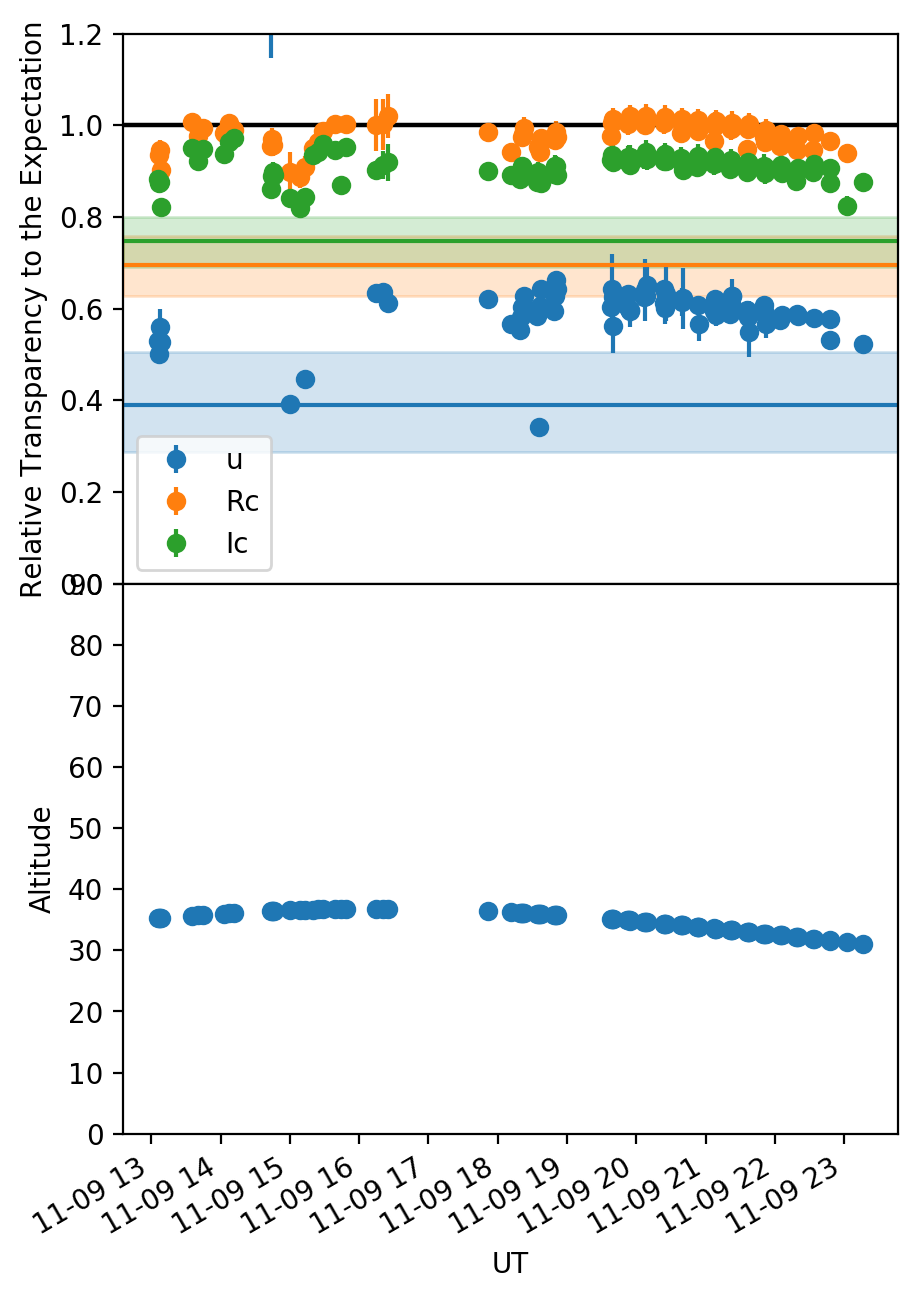

In [32]:
Ali = EarthLocation.from_geodetic(lat=32.31373, lon=80.030018, height=5100)
mkplot(result, Ali, target, 6, 0.74 )

# Hiroshima data

In [33]:
target = "hiroshima/object*-2/object*.new"
offset = [9.4,60.2]

In [11]:
Hresult = loopover(target,offset)

0/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.859293035  26.7552611413  
CRPIX : 1329.98977661  637.075813293  
CD1_1 CD1_2  : 0.000182839857234  4.6966737741e-05  
CD2_1 CD2_2  : -4.74463661656e-05  0.000181238369845  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920115633-2/object20140920115633-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
0/32
None [9.4, 60.2]
hiroshima/object20140920115633-1/object20140920115633-1.new
0/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.859293035  26.7552611413  
CRPIX : 1320.58977661  576.87581329  
PC1_1 PC1_2  : 0.000182839857234  4.6966737741e-05  
PC2_1 PC2_2  : -4.74463661656e-05  0.000181238369845  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920115633-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
1/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829840538  26.4692911877  
CRPIX : 940.980690002  1238.87361145  
CD1_1 CD1_2  : 0.000181165198079  5.3158568584e-05  
CD2_1 CD2_2  : -5.36535744709e-05  0.00017943345243  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120001-2/object20140920120001-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
1/32
None [9.4, 60.2]
hiroshima/object20140920120001-1/object20140920120001-1.new
1/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829840538  26.4692911877  
CRPIX : 931.58069  1178.67361145  
PC1_1 PC1_2  : 0.000181165198079  5.3158568584e-05  
PC2_1 PC2_2  : -5.36535744709e-05  0.00017943345243  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120001-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
2/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795182198  26.4330717199  
CRPIX : 782.564094543  974.006072998  
CD1_1 CD1_2  : 0.000179675232663  5.78527249852e-05  
CD2_1 CD2_2  : -5.83881512608e-05  0.000178075015338  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120500-2/object20140920120500-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
2/32
None [9.4, 60.2]
hiroshima/object20140920120500-1/object20140920120500-1.new
FLUX_R


{'median': 0.16887639463338544, 'std': 0.0}
2/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795182198  26.4330717199  
CRPIX : 773.164094543  913.806072998  
PC1_1 PC1_2  : 0.000179675232663  5.78527249852e-05  
PC2_1 PC2_2  : -5.83881512608e-05  0.000178075015338  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120500-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
3/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829827303  26.4692718802  
CRPIX : 843.171981812  1188.73033142  
CD1_1 CD1_2  : 0.00017869731816  6.09299388781e-05  
CD2_1 CD2_2  : -6.14631257044e-05  0.000177033777795  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120807-2/object20140920120807-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
3/32
None [9.4, 60.2]
hiroshima/object20140920120807-1/object20140920120807-1.new
FLUX_R


{'median': 0.4701966225587444, 'std': 0.0}
3/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829827303  26.4692718802  
CRPIX : 833.77198181  1128.53033142  
PC1_1 PC1_2  : 0.00017869731816  6.09299388781e-05  
PC2_1 PC2_2  : -6.14631257044e-05  0.000177033777795  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120807-0.fits
FLUX_U


{'median': 0.3747975227789777, 'std': 0.0}
4/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829826016  26.4692783665  
CRPIX : 834.087013245  1184.00598145  
CD1_1 CD1_2  : 0.000178466743384  6.15974578649e-05  
CD2_1 CD2_2  : -6.21449535609e-05  0.000176790499684  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120845-2/object20140920120845-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
4/32
None [9.4, 60.2]
hiroshima/object20140920120845-1/object20140920120845-1.new
FLUX_R


{'median': 0.3636885979853498, 'std': 0.0}
4/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829826016  26.4692783665  
CRPIX : 824.68701325  1123.80598145  
PC1_1 PC1_2  : 0.000178466743384  6.15974578649e-05  
PC2_1 PC2_2  : -6.21449535609e-05  0.000176790499684  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120845-0.fits
FLUX_U


{'median': 0.2943563074789591, 'std': 0.0}
5/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829825552  26.4692801654  
CRPIX : 828.55065918  1180.70562744  
CD1_1 CD1_2  : 0.000178305155641  6.20831717902e-05  
CD2_1 CD2_2  : -6.26292852364e-05  0.000176623992019  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120911-2/object20140920120911-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
5/32
None [9.4, 60.2]
hiroshima/object20140920120911-1/object20140920120911-1.new
FLUX_R


{'median': 0.21836101164939015, 'std': 0.0}
5/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829825552  26.4692801654  
CRPIX : 819.15065918  1120.50562744  
PC1_1 PC1_2  : 0.000178305155641  6.20831717902e-05  
PC2_1 PC2_2  : -6.26292852364e-05  0.000176623992019  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120911-0.fits
FLUX_U


{'median': 0.16878747334270205, 'std': 0.0}
6/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621875553  28.8728405204  
CRPIX : 659.670463562  1012.76145935  
CD1_1 CD1_2  : 0.000181929767721  5.03760989295e-05  
CD2_1 CD2_2  : -5.08725625885e-05  0.000180322270452  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121217-2/object20140920121217-2.new
FLUX_I


{'median': 0.370784954152894, 'std': 0.0}
6/32
None [9.4, 60.2]
hiroshima/object20140920121217-1/object20140920121217-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
6/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621875553  28.8728405204  
CRPIX : 650.270463562  952.56145935  
PC1_1 PC1_2  : 0.000181929767721  5.03760989295e-05  
PC2_1 PC2_2  : -5.08725625885e-05  0.000180322270452  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121217-0.fits
FLUX_U


{'median': 0.27636718953280603, 'std': 0.0}
7/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654942418  28.8930940869  
CRPIX : 1114.81517029  658.117660522  
CD1_1 CD1_2  : -0.000150018864748  0.000113705582776  
CD2_1 CD2_2  : -0.000114746539038  -0.000148688619326  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920142558-2/object20140920142558-2.new
FLUX_I


{'median': 0.4949024834426077, 'std': 0.0}
7/32
None [9.4, 60.2]
hiroshima/object20140920142558-1/object20140920142558-1.new
FLUX_R


{'median': 0.606916581954461, 'std': 0.0}
7/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654942418  28.8930940869  
CRPIX : 1105.41517029  597.91766052  
PC1_1 PC1_2  : -0.000150018864748  0.000113705582776  
PC2_1 PC2_2  : -0.000114746539038  -0.000148688619326  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920142558-0.fits
FLUX_U


{'median': 0.3452553525041533, 'std': 0.0}
8/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918215  28.8930785543  
CRPIX : 1112.45500183  655.803936005  
CD1_1 CD1_2  : -0.000150216691204  0.000113462044382  
CD2_1 CD2_2  : -0.00011447013943  -0.000148894548395  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920142653-2/object20140920142653-2.new
FLUX_I


{'median': 0.5039448747293326, 'std': 0.0}
8/32
None [9.4, 60.2]
hiroshima/object20140920142653-1/object20140920142653-1.new
FLUX_R


{'median': 0.49835487204437134, 'std': 0.0}
8/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918215  28.8930785543  
CRPIX : 1103.05500183  595.603936  
PC1_1 PC1_2  : -0.000150216691204  0.000113462044382  
PC2_1 PC2_2  : -0.00011447013943  -0.000148894548395  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920142653-0.fits
FLUX_U


{'median': 0.3568465516056072, 'std': 0.0}
9/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918727  28.8930744256  
CRPIX : 1111.36418152  655.322937012  
CD1_1 CD1_2  : -0.000150284379102  0.000113383656971  
CD2_1 CD2_2  : -0.000114368793812  -0.000148975970162  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920142712-2/object20140920142712-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
9/32
None [9.4, 60.2]
hiroshima/object20140920142712-1/object20140920142712-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
9/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654918727  28.8930744256  
CRPIX : 1101.96418152  595.12293701  
PC1_1 PC1_2  : -0.000150284379102  0.000113383656971  
PC2_1 PC2_2  : -0.000114368793812  -0.000148975970162  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920142712-0.fits
FLUX_U


{'median': 0.3475729482205565, 'std': 0.0}
10/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654912417  28.8930907898  
CRPIX : 1100.59382629  647.629123688  
CD1_1 CD1_2  : -0.000151246238785  0.000112110988623  
CD2_1 CD2_2  : -0.000113088645122  -0.000149906471407  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143156-2/object20140920143156-2.new
FLUX_I


{'median': 0.49551256349820116, 'std': 0.0}
10/32
None [9.4, 60.2]
hiroshima/object20140920143156-1/object20140920143156-1.new
FLUX_R


{'median': 0.6020510200311993, 'std': 0.0}
10/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654912417  28.8930907898  
CRPIX : 1091.19382629  587.42912369  
PC1_1 PC1_2  : -0.000151246238785  0.000112110988623  
PC2_1 PC2_2  : -0.000113088645122  -0.000149906471407  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143156-0.fits
FLUX_U


{'median': 0.3639265377840046, 'std': 0.0}
11/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654915208  28.8930989097  
CRPIX : 1098.80174255  646.038059235  
CD1_1 CD1_2  : -0.000151492141244  0.000111803585574  
CD2_1 CD2_2  : -0.000112759196939  -0.00015013193223  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143315-2/object20140920143315-2.new
FLUX_I


{'median': 0.4752853828980958, 'std': 0.0}
11/32
None [9.4, 60.2]
hiroshima/object20140920143315-1/object20140920143315-1.new
FLUX_R


{'median': 0.5201969685991079, 'std': 0.04828875870892402}
11/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654915208  28.8930989097  
CRPIX : 1089.40174255  585.83805923  
PC1_1 PC1_2  : -0.000151492141244  0.000111803585574  
PC2_1 PC2_2  : -0.000112759196939  -0.00015013193223  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143315-0.fits
FLUX_U


{'median': 0.3414094161814938, 'std': 0.0}
12/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906226  28.8931045427  
CRPIX : 1095.60987854  644.036769867  
CD1_1 CD1_2  : -0.000151771152872  0.000111437014607  
CD2_1 CD2_2  : -0.000112386359412  -0.000150426068811  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143448-2/object20140920143448-2.new
FLUX_I


{'median': 0.4692160651825583, 'std': 0.0}
12/32
None [9.4, 60.2]
hiroshima/object20140920143448-1/object20140920143448-1.new
FLUX_R


{'median': 0.5077340815341476, 'std': 0.04684726162619751}
12/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906226  28.8931045427  
CRPIX : 1086.20987854  583.83676987  
PC1_1 PC1_2  : -0.000151771152872  0.000111437014607  
PC2_1 PC2_2  : -0.000112386359412  -0.000150426068811  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143448-0.fits
FLUX_U


{'median': 0.32989794554834917, 'std': 0.0}
13/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298767  26.4305843241  
CRPIX : 862.596069336  1369.99714661  
CD1_1 CD1_2  : -0.00013815418368  0.000127768749818  
CD2_1 CD2_2  : -0.000128845162284  -0.000136784329883  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143819-2/object20140920143819-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
13/32
None [9.4, 60.2]
hiroshima/object20140920143819-1/object20140920143819-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
13/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298767  26.4305843241  
CRPIX : 853.19606934  1309.79714661  
PC1_1 PC1_2  : -0.00013815418368  0.000127768749818  
PC2_1 PC2_2  : -0.000128845162284  -0.000136784329883  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143819-0.fits
FLUX_U


{'median': 0.34920193558870566, 'std': 0.0}
14/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941300307  26.4305923303  
CRPIX : 859.839385986  1368.4455719  
CD1_1 CD1_2  : -0.000138286107082  0.000127632640464  
CD2_1 CD2_2  : -0.000128680821201  -0.000136949924701  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143840-2/object20140920143840-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
14/32
None [9.4, 60.2]
hiroshima/object20140920143840-1/object20140920143840-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
14/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941300307  26.4305923303  
CRPIX : 850.43938599  1308.2455719  
PC1_1 PC1_2  : -0.000138286107082  0.000127632640464  
PC2_1 PC2_2  : -0.000128680821201  -0.000136949924701  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143840-0.fits
FLUX_U


{'median': 0.35355133368116126, 'std': 0.0}
15/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941303864  26.4305897054  
CRPIX : 857.345809937  1366.88667297  
CD1_1 CD1_2  : -0.000138416782055  0.000127463296625  
CD2_1 CD2_2  : -0.000128532313649  -0.000137074423344  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143905-2/object20140920143905-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
15/32
None [9.4, 60.2]
hiroshima/object20140920143905-1/object20140920143905-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
15/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941303864  26.4305897054  
CRPIX : 847.94580994  1306.68667297  
PC1_1 PC1_2  : -0.000138416782055  0.000127463296625  
PC2_1 PC2_2  : -0.000128532313649  -0.000137074423344  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143905-0.fits
FLUX_U


{'median': 0.33240406316687904, 'std': 0.0}
16/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.79521348  26.4331376175  
CRPIX : 1348.22584534  878.111068726  
CD1_1 CD1_2  : -0.000138773219459  0.000127030300558  
CD2_1 CD2_2  : -0.000128239668396  -0.000137479839647  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920144030-2/object20140920144030-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
16/32
None [9.4, 60.2]
hiroshima/object20140920144030-1/object20140920144030-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
16/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.79521348  26.4331376175  
CRPIX : 1338.82584534  817.91106873  
PC1_1 PC1_2  : -0.000138773219459  0.000127030300558  
PC2_1 PC2_2  : -0.000128239668396  -0.000137479839647  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920144030-0.fits
FLUX_U


{'median': 0.37045581968468116, 'std': 0.0}
17/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941310753  26.4305823936  
CRPIX : 845.758071899  1360.6408844  
CD1_1 CD1_2  : -0.000139146019823  0.000126721440238  
CD2_1 CD2_2  : -0.00012775133771  -0.000137857611834  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920144103-2/object20140920144103-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
17/32
None [9.4, 60.2]
hiroshima/object20140920144103-1/object20140920144103-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
17/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941310753  26.4305823936  
CRPIX : 836.3580719  1300.4408844  
PC1_1 PC1_2  : -0.000139146019823  0.000126721440238  
PC2_1 PC2_2  : -0.00012775133771  -0.000137857611834  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920144103-0.fits
FLUX_U


{'median': 0.35608261940091923, 'std': 0.0}
18/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829835082  26.4692858286  
CRPIX : 870.452663422  1204.2563324  
CD1_1 CD1_2  : 0.000179435295732  5.86472336084e-05  
CD2_1 CD2_2  : -5.91726321756e-05  0.00017778079004  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120547-2/object20140920120547-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
18/32
None [9.4, 60.2]
hiroshima/object20140920120547-1/object20140920120547-1.new
FLUX_R


{'median': 0.28803497141503537, 'std': 0.009670820487142628}
18/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.829835082  26.4692858286  
CRPIX : 861.05266342  1144.0563324  
PC1_1 PC1_2  : 0.000179435295732  5.86472336084e-05  
PC2_1 PC2_2  : -5.91726321756e-05  0.00017778079004  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120547-0.fits
FLUX_U


{'median': 0.20649738606764995, 'std': 0.0}
19/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795179379  26.4330761825  
CRPIX : 809.360534668  991.127502441  
CD1_1 CD1_2  : 0.000180425261011  5.55043750316e-05  
CD2_1 CD2_2  : -5.59857185973e-05  0.00017881586396  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920120231-2/object20140920120231-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
19/32
None [9.4, 60.2]
hiroshima/object20140920120231-1/object20140920120231-1.new
FLUX_R


{'median': 0.4919767876550962, 'std': 0.0}
19/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.795179379  26.4330761825  
CRPIX : 799.960534668  930.927502441  
PC1_1 PC1_2  : 0.000180425261011  5.55043750316e-05  
PC2_1 PC2_2  : -5.59857185973e-05  0.00017881586396  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920120231-0.fits
FLUX_U


{'median': 0.34846027715696704, 'std': 0.0}
20/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658833372  28.952704987  
CRPIX : 737.565658569  1484.5736084  
CD1_1 CD1_2  : 0.000182471702744  4.85195060572e-05  
CD2_1 CD2_2  : -4.9072991575e-05  0.000180820250636  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121047-2/object20140920121047-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
20/32
None [9.4, 60.2]
hiroshima/object20140920121047-1/object20140920121047-1.new
FLUX_R


{'median': 0.45509596675659403, 'std': 0.04402430162918011}
20/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658833372  28.952704987  
CRPIX : 728.16565857  1424.3736084  
PC1_1 PC1_2  : 0.000182471702744  4.85195060572e-05  
PC2_1 PC2_2  : -4.9072991575e-05  0.000180820250636  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121047-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
21/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658827111  28.9527033357  
CRPIX : 718.21660614  1473.74998474  
CD1_1 CD1_2  : 0.000182060606433  4.98728615829e-05  
CD2_1 CD2_2  : -5.04582590945e-05  0.000180444424581  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121154-2/object20140920121154-2.new
FLUX_I


{'median': 0.40960480750881456, 'std': 0.0}
21/32
None [9.4, 60.2]
hiroshima/object20140920121154-1/object20140920121154-1.new
FLUX_R


{'median': 0.44058616576151904, 'std': 0.044596781865173574}
21/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.658827111  28.9527033357  
CRPIX : 708.81660614  1413.54998474  
PC1_1 PC1_2  : 0.000182060606433  4.98728615829e-05  
PC2_1 PC2_2  : -5.04582590945e-05  0.000180444424581  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121154-0.fits
FLUX_U


{'median': 0.29356552062366903, 'std': 0.0}
22/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621901182  28.8728673928  
CRPIX : 649.84866333  1006.13569641  
CD1_1 CD1_2  : 0.000181723560366  5.12591753425e-05  
CD2_1 CD2_2  : -5.17023479008e-05  0.000180105086595  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121250-2/object20140920121250-2.new
FLUX_I


{'median': 0.35587132719337294, 'std': 0.0}
22/32
None [9.4, 60.2]
hiroshima/object20140920121250-1/object20140920121250-1.new
FLUX_R


{'median': 0.3480509905773634, 'std': 0.0}
22/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621901182  28.8728673928  
CRPIX : 640.44866333  945.93569641  
PC1_1 PC1_2  : 0.000181723560366  5.12591753425e-05  
PC2_1 PC2_2  : -5.17023479008e-05  0.000180105086595  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121250-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
23/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.62190413  28.8728727848  
CRPIX : 635.964408875  996.522781372  
CD1_1 CD1_2  : 0.000181386477649  5.24877758417e-05  
CD2_1 CD2_2  : -5.29505277399e-05  0.000179761592178  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121346-2/object20140920121346-2.new
FLUX_I


{'median': 0.3721665142196157, 'std': 0.0}
23/32
None [9.4, 60.2]
hiroshima/object20140920121346-1/object20140920121346-1.new
FLUX_R


{'median': 0.3607366778843597, 'std': 0.0}
23/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.62190413  28.8728727848  
CRPIX : 626.564408875  936.322781372  
PC1_1 PC1_2  : 0.000181386477649  5.24877758417e-05  
PC2_1 PC2_2  : -5.29505277399e-05  0.000179761592178  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121346-0.fits
FLUX_U


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
24/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621892489  28.8728494797  
CRPIX : 613.044868469  981.596115112  
CD1_1 CD1_2  : 0.000180755352109  5.4420323125e-05  
CD2_1 CD2_2  : -5.48999531627e-05  0.000179170112683  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920121510-2/object20140920121510-2.new
FLUX_I


{'median': 0.2786688462410021, 'std': 0.0}
24/32
None [9.4, 60.2]
hiroshima/object20140920121510-1/object20140920121510-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
24/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.621892489  28.8728494797  
CRPIX : 603.644868469  921.396115112  
PC1_1 PC1_2  : 0.000180755352109  5.4420323125e-05  
PC2_1 PC2_2  : -5.48999531627e-05  0.000179170112683  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920121510-0.fits
FLUX_U


{'median': 0.22708225022007264, 'std': 0.0}
25/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654905693  28.8930945817  
CRPIX : 1099.21044922  646.575241089  
CD1_1 CD1_2  : -0.000151413696979  0.000111909691477  
CD2_1 CD2_2  : -0.000112886838455  -0.000150061931521  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143247-2/object20140920143247-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
25/32
None [9.4, 60.2]
hiroshima/object20140920143247-1/object20140920143247-1.new
FLUX_R


{'median': 0.5739296059898021, 'std': 0.0}
25/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654905693  28.8930945817  
CRPIX : 1089.81044922  586.37524109  
PC1_1 PC1_2  : -0.000151413696979  0.000111909691477  
PC2_1 PC2_2  : -0.000112886838455  -0.000150061931521  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143247-0.fits
FLUX_U


{'median': 0.34879885687807166, 'std': 0.0}
26/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654902925  28.8931033374  
CRPIX : 1097.4936676  645.580097198  
CD1_1 CD1_2  : -0.000151588032843  0.000111677659776  
CD2_1 CD2_2  : -0.000112633984769  -0.000150224252273  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143341-2/object20140920143341-2.new
FLUX_I


{'median': 0.4851573159232539, 'std': 0.0}
26/32
None [9.4, 60.2]
hiroshima/object20140920143341-1/object20140920143341-1.new
FLUX_R


{'median': 0.5339728058322035, 'std': 0.05050453265946833}
26/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654902925  28.8931033374  
CRPIX : 1088.0936676  585.3800972  
PC1_1 PC1_2  : -0.000151588032843  0.000111677659776  
PC2_1 PC2_2  : -0.000112633984769  -0.000150224252273  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143341-0.fits
FLUX_U


{'median': 0.3539724643076277, 'std': 0.0}
27/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906895  28.8931028962  
CRPIX : 1096.7122345  644.262443542  
CD1_1 CD1_2  : -0.000151674542898  0.000111552768193  
CD2_1 CD2_2  : -0.000112501300292  -0.000150319792086  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143415-2/object20140920143415-2.new
FLUX_I


{'median': 0.48855742897646337, 'std': 0.0}
27/32
None [9.4, 60.2]
hiroshima/object20140920143415-1/object20140920143415-1.new
FLUX_R


{'median': 0.536840530724762, 'std': 0.050887920787593605}
27/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 327.654906895  28.8931028962  
CRPIX : 1087.3122345  584.06244354  
PC1_1 PC1_2  : -0.000151674542898  0.000111552768193  
PC2_1 PC2_2  : -0.000112501300292  -0.000150319792086  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143415-0.fits
FLUX_U


{'median': 0.3599735181498128, 'std': 0.0}
28/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298508  26.4305985567  
CRPIX : 874.251556396  1376.40873718  
CD1_1 CD1_2  : -0.000137475772635  0.000128522392813  
CD2_1 CD2_2  : -0.000129567466338  -0.000136129270186  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143628-2/object20140920143628-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
28/32
None [9.4, 60.2]
hiroshima/object20140920143628-1/object20140920143628-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
28/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941298508  26.4305985567  
CRPIX : 864.8515564  1316.20873718  
PC1_1 PC1_2  : -0.000137475772635  0.000128522392813  
PC2_1 PC2_2  : -0.000129567466338  -0.000136129270186  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143628-0.fits
FLUX_U


{'median': 0.3328986145866825, 'std': 0.0}
29/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941302716  26.4305942249  
CRPIX : 865.060119629  1370.24397278  
CD1_1 CD1_2  : -0.000138032340359  0.000127908044633  
CD2_1 CD2_2  : -0.000128990043351  -0.000136679197463  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143759-2/object20140920143759-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
29/32
None [9.4, 60.2]
hiroshima/object20140920143759-1/object20140920143759-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
29/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941302716  26.4305942249  
CRPIX : 855.66011963  1310.04397278  
PC1_1 PC1_2  : -0.000138032340359  0.000127908044633  
PC2_1 PC2_2  : -0.000128990043351  -0.000136679197463  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143759-0.fits
FLUX_U


{'median': 0.368311971058741, 'std': 0.0}
30/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941296382  26.4305964488  
CRPIX : 854.955535889  1366.1072998  
CD1_1 CD1_2  : -0.000138577832128  0.000127302645255  
CD2_1 CD2_2  : -0.000128385910122  -0.000137250131411  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143931-2/object20140920143931-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
30/32
None [9.4, 60.2]
hiroshima/object20140920143931-1/object20140920143931-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
30/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941296382  26.4305964488  
CRPIX : 845.55553589  1305.9072998  
PC1_1 PC1_2  : -0.000138577832128  0.000127302645255  
PC2_1 PC2_2  : -0.000128385910122  -0.000137250131411  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143931-0.fits
FLUX_U


{'median': 0.371698485438296, 'std': 0.0}
31/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941304221  26.4305935007  
CRPIX : 851.707122803  1363.96255493  
CD1_1 CD1_2  : -0.00013876408194  0.000127110255838  
CD2_1 CD2_2  : -0.000128189166382  -0.000137434709386  
NAXIS : 2098  2048 [9.4, 60.2]
hiroshima/object20140920143956-2/object20140920143956-2.new
FLUX_I


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
31/32
None [9.4, 60.2]
hiroshima/object20140920143956-1/object20140920143956-1.new
FLUX_R


/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3055: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/utsumi/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdim

{'median': nan, 'std': nan}
31/32
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 329.941304221  26.4305935007  
CRPIX : 842.3071228  1303.76255493  
PC1_1 PC1_2  : -0.00013876408194  0.000127110255838  
PC2_1 PC2_2  : -0.000128189166382  -0.000137434709386  
CDELT : 1.0  1.0  
NAXIS : 0  0 [9.4, 60.2]
hiroshima/object20140920143956-0.fits
FLUX_U
{'median': 0.37297773903582704, 'std': 0.0}


/home/utsumi/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname UT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
/home/utsumi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


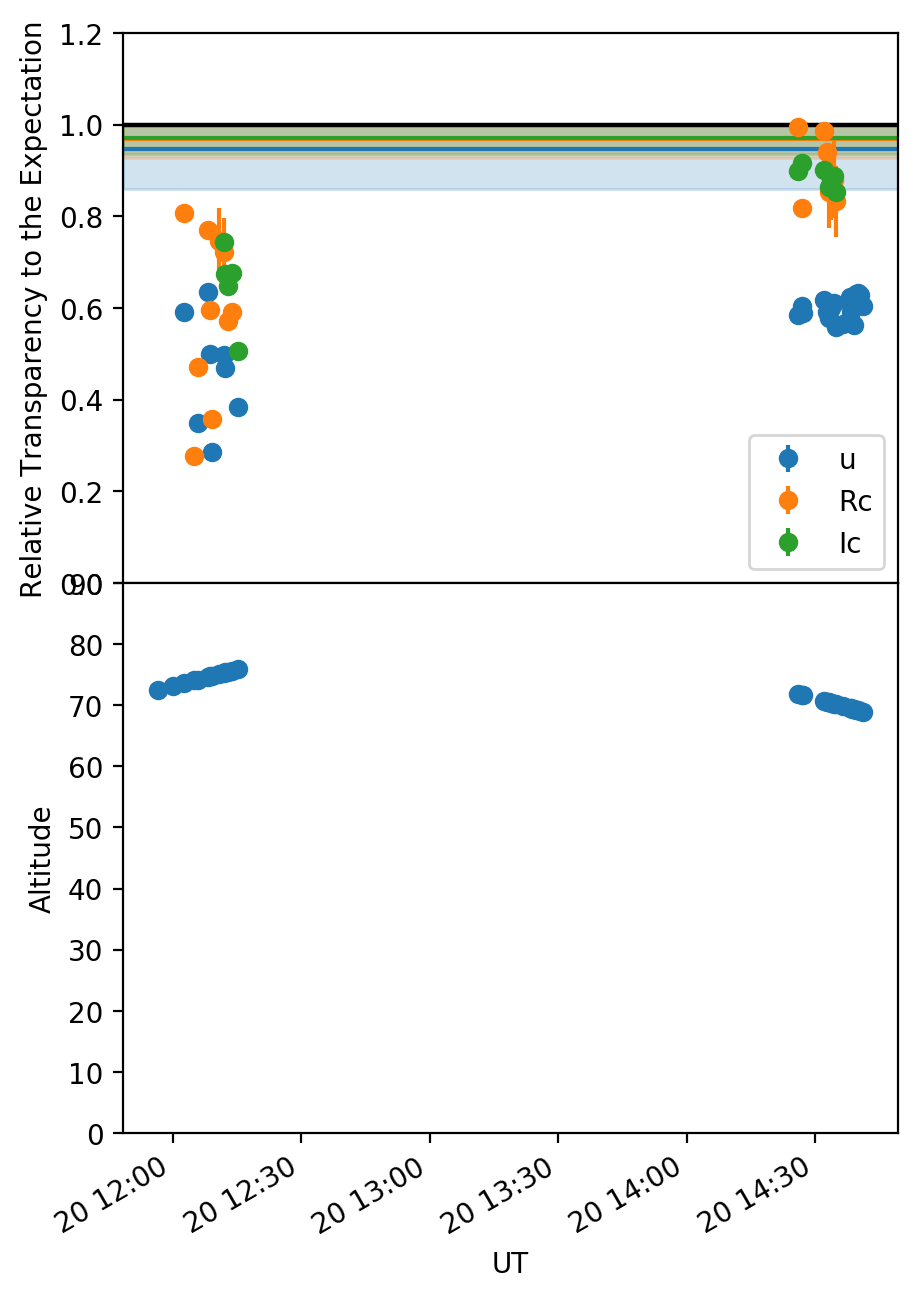

In [34]:
target = "hiroshima/object*-2/object*.new"
Hiroshima = EarthLocation.from_geodetic(lat=34.3775, lon=132.7767, height=510)
mkplot(Hresult, Hiroshima, target, 1, 1)

# Playground

In [13]:
# arXiv:astro-ph/9907229
def acfregister(path,refpath):
    data, header=preprocess(path)
    refdata, refheader=preprocess(refpath)

    catalogs = []
    for img in [data, refdata]:
        mean, median, std = sigma_clipped_stats(img, sigma=3.0)  
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std, brightest=100)
        sources=daofind(img-median)
        # define positions where we measure
        positions = numpy.transpose([sources["xcentroid"], sources["ycentroid"]])
        catalogs.append(positions)
    return catalogs
    
catalogs = acfregister("HT0000405-0.fits","HT0000405-2/HT0000405-2.new")

FileNotFoundError: [Errno 2] No such file or directory: 'HT0000405-0.fits'

In [ ]:
catalogs[0].shape, catalogs[1].shape

In [ ]:
from scipy.signal import correlate2d
def getscalerot( catalogs, plot=False ):
    # determine scale and rotation
    if plot:
        fig = pylab.figure(figsize=(5,5),dpi=200)
    Harr = []
    for i in range(2):
        d = []
        phi = []
        # calculate d and phi for all possible pairs
        for a in catalogs[i]:
            for b in catalogs[i]:
                d.append( numpy.linalg.norm(a-b) )
                phi.append( numpy.arctan2(*(a-b)) )
        d = numpy.array(d)
        phi = numpy.array(phi)
        ld = numpy.log(d)
        X = numpy.arange(3,9,0.05)
        Y = numpy.arange(-numpy.pi,numpy.pi,0.05)
        # make a 2D histogram
        H, xedges, yedges = numpy.histogram2d(ld,phi,bins=[X,Y])
        Harr.append(H)
        if plot:
            pylab.subplot("13{}".format(i+1))
            pylab.imshow(H,origin="lower",extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
            pylab.ylabel(r"$\log(d)$")
            pylab.xlabel(r"$\phi$")
    # correlate them
    corr = correlate2d(Harr[0],Harr[1], boundary='symm', mode='same')
    y, x = numpy.unravel_index(numpy.argmax(corr), corr.shape)
    cy,cx = (numpy.array(2*yedges[-1],2*xedges[-1])/(numpy.array(corr.shape))*(numpy.array([y,x])+0.5)+numpy.array(-yedges[-1],-xedges[-1]))
    if plot:
        pylab.subplot(133)
        pylab.imshow(corr,origin="lower",extent=[-yedges[-1], yedges[-1], -xedges[-1], xedges[-1]])
#        pylab.scatter(cx,cy,marker="x",alpha=0.5)
        pylab.ylabel(r"$\log(d)$")
        pylab.xlabel(r"$\phi$")
    return cx,numpy.exp(cy)

In [ ]:
phi, scale = getscalerot([catalogs[0],catalogs[1]],plot=True)
print(phi,scale)

In [ ]:
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import coordinates as coord
fig = pylab.figure(figsize=(5,5),dpi=150)

Ali = EarthLocation.from_geodetic(lat=32.31373, lon=80.030018, height=5100)
files = glob.glob("fwhm/HT*-2/HT*.new")[:-1]
obstime = []
ra = []
dec = []
for afile in files:
    with fits.open(afile) as fh:
        header = fh[0].header
        obstime.append(parse("{}T{} UT ".format(header["DATE-OBS"],header["UT"])))
        ra  = header["RA"]
        dec = header["DEC"]

aa_frame = coord.AltAz(
    obstime=obstime,
    location=Ali)
ret = SkyCoord(ra,dec,unit=("hour","deg")).transform_to(aa_frame)
pylab.plot_date(ret.obstime.value, ret.alt)
fig.autofmt_xdate()
pylab.tight_layout()
#print (ret.obstime, ret.az, ret.alt)

In [ ]:
pylab.plot(1/numpy.cos((90-ret.alt.degree)/180*numpy.pi), result["Ic"]["median"],"o")
pylab.ylim(0.3,0.4)